In [55]:
from common import *

import xml.etree.ElementTree as ET
from pymongo import MongoClient
import pymongo
from matplotlib import pyplot as plt

from pymystem3 import Mystem
from bson.objectid import ObjectId
import re
from bson.son import SON
import gridfs
from pprint import pprint

from matplotlib import pyplot as plt

In [2]:
fname = join(join(DATA_FOLDER, 'rawdata'), 'all_docs_raw.txt')

In [3]:
# all_docs = glob(join(DATA_FOLDER, 'rawdata') + '/**/*.xml', recursive=True)
# all_docs = sorted(all_docs)
# with open(fname, mode='wt', encoding='utf-8') as f:
#     f.write('\n'.join(all_docs))

In [76]:
with open(fname, mode='r', encoding='utf-8') as f:
    all_docs = f.read().splitlines()

In [ ]:
len(all_docs)

In [ ]:
def get_node(root, name, lang='ru'):
    for node in root.iter(name):
        if 'lang' in node.attrib:
            if node.attrib['lang'].lower() == lang:
                return node
        else:
            return node

In [ ]:
def parse_xml(fname, mstem, lemmatize=True, save_raw=True):
    doc = {}

    with open(fname, 'r', encoding='utf8') as f:
        text = f.read()
        text = text.replace('&deg', 'deg')
    
    try:
        root = ET.fromstring(text)
    except:
        print(fname)
        return
    
    doc.update(root.attrib)

    raw_texts = {}
    
    SDOBI = get_node(root, 'SDOBI')
    if SDOBI is not None:
        node = SDOBI.find('./B500/ru-b540/ru-b542')
        if node is not None:
            raw_texts['name'] = node.text.lower()
        else:
            print(fname)            
    else:
        print('no SDOBI: ' + fn)

    node = get_node(root, 'abstract')
    if node is not None:
        raw_texts['abstract'] = ' '.join(node.itertext()).lower()

    if SDOBI is not None:
        node = SDOBI.find('./B500/B560/ru-b560')
        if node is not None:
            doc['ru-b560'] = ' '.join(node.itertext())

    node = get_node(root, 'description')
    if node is not None:
        raw_texts['description'] = ' '.join(node.itertext()).lower()

    node = get_node(root, 'claims')
    if node is not None:
        raw_texts['claims'] = ' '.join(node.itertext()).lower()        
    
    
    for k,v in raw_texts.items():
        if save_raw:
            doc[k + '_raw'] = v
        if lemmatize:
            doc[k] = ''.join(mstem.lemmatize(v))    
    
    return doc

# Test

In [7]:
afile = '../data/rawdata/2016/RU/A/20161227/2015116494/2015116494.xml'
c1file = '../data/rawdata/2016/RU/C1/20161227/0002605713/0002605713.xml'
c2file = '../data/rawdata/2016/RU/C2/20160127/0002573901/0002573901.xml'
ufile = '../data/rawdata/2016/RU/U1/20161210/0000166582/0000166582.xml'

In [8]:
mstem = Mystem()
doc = parse_xml(c2file, mstem)

Installing mystem to /home/administrator/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz


In [21]:
print(doc['description'])

область техника настоящий изобретение относиться к способ получение поверхностный покрытие на основа поливинилхлорид (пвх), содержать слой износ на основа пвх и слой на основа поливиниловый спирт. предшествующий уровень техника поверхностный покрытие на основа пвх широко применять для декорирование сооружение, дом или транспортный средство. однако поверхностный покрытие на основа пвх обладать недостаток высвобождение летучий органический соединение (лос), некоторый из который токсичный. для уменьшение или предотвращение высвобождение лос быть предлагать замещать летучий соединение нелетучий соединение. однако этот приводить к значительный снижение жесткость поверхностный покрытие, в тот время как жесткость являться важный требование для упругий поверхностный покрытие, особенно напольный покрытие. также быть предлагать применение полиэфирный или полиамидный слой в качество защитный слой или в качество промежуточный слой в многослойный поверхностный покрытие. поливинилспиртовой (пвс) сло

In [9]:
doc

{'abstract': 'изобретение относиться к способ получение поверхностный покрытие, содержать этап обеспечение слой износ на основа пвх (1), по существо, свободный от неорганический наполнитель, нанесение на упоминать слой на основа пвх (1) композиция верхний покрытие, содержать поливиниловый спирт (пвс) и соединение силан, содержать по меньший мера один аминогруппа, нагревание упоминать слой на основа пвх (1) и упоминать композиция верхний покрытие при температура, эквивалентный или превосходить 150°c, для образование верхний покрытие слой износ (2). результат являться получение поверхностный покрытие, сочетать свойство физический устойчивость и свойство химический и газовый барьер. 2 н. и 12 з.п. ф-лы, 4 ил., 6 табла.\n',
 'abstract_raw': 'изобретение относится к способу получения поверхностного покрытия, содержащему этапы обеспечения слоя износа на основе пвх (1), по существу, свободного от неорганических наполнителей, нанесения на упомянутый слой на основе пвх (1) композиции верхнего п

# Fill database with data

In [4]:
client = MongoClient()
db = client.fips

In [6]:
# result = db.patents.create_index([('doc-number', pymongo.ASCENDING),
#                                    ('kind', pymongo.ASCENDING),
#                                    ('country', pymongo.ASCENDING),
#                                    ('date-publ', pymongo.ASCENDING)], unique=True)
# sorted(list(db.patents.index_information()))

In [6]:
def save_to_mongodb(doc_list):
    client = MongoClient()
    db = client.fips
    patents = db.patents
    
    mstem = Mystem()
    
    for fn in doc_list:
        doc = parse_xml(fn, mstem, True, True)
        if doc is not None:
            patents.insert_one(doc)

In [12]:
len(all_docs)//(cpu_count*100)

395

In [ ]:
split_on = len(all_docs)//(cpu_count*100)

for i,sub_docs in enumerate(tqdm(np.array_split(all_docs, split_on))):
    ! rm -f ../data/out
    ! echo {i} >> ../data/out
    
    parallelizer = Parallel(n_jobs=cpu_count)

    # this iterator returns the functions to execute for each task
    tasks_iterator = ( delayed(save_to_mongodb)(list_block) for 
                      list_block in grouper(100, sub_docs) ) 
    result = parallelizer( tasks_iterator )

 21%|██▏       | 84/395 [23:52<54:56, 10.60s/it]  

../data/rawdata/1999/RU/C1/19990220/0002126409/0002126409.xml


 93%|█████████▎| 369/395 [2:40:03<29:43, 68.61s/it]t]

../data/rawdata/2015/Patents/xrfd201503/DOC/RUNWC2/000/000/002/560/425/document.xml


100%|██████████| 395/395 [2:58:26<00:00, 44.67s/it]


In [16]:
# docs = []
# mstem = Mystem()

# for fn in tqdm(all_docs):
#     doc = parse_xml(fn, mstem, False, False)
#     if doc is not None:
#         patents.insert_one(doc)
# #         docs.append(doc)

In [ ]:
# patents.insert_many(docs)

# Analyze data

In [4]:
client = MongoClient()
db = client.fips

In [7]:
pipeline = [
     {"$group": {"_id": "$kind", "count": {"$sum": 1}}},
     {"$sort": SON([("count", -1), ("_id", -1)])}
 ]

pprint.pprint(list(db.patents.aggregate(pipeline)))

[{'_id': 'A ', 'count': 438164},
 {'_id': 'C1', 'count': 380857},
 {'_id': 'C2', 'count': 214003},
 {'_id': 'U1', 'count': 167301},
 {'_id': 'A1', 'count': 60184},
 {'_id': 'C ', 'count': 2527},
 {'_id': 'C9', 'count': 1372},
 {'_id': 'A2', 'count': 1028},
 {'_id': 'A3', 'count': 824},
 {'_id': 'U8', 'count': 650},
 {'_id': 'C8', 'count': 13},
 {'_id': 'A4', 'count': 13},
 {'_id': 'A8', 'count': 4}]


In [9]:
db.patents.find({ 'ru-b560': {'$exists': True}}).count()

591782

In [13]:
pipeline = [
    {"$match":{"ru-b560":{'$exists': True}}},
    {"$group": {"_id": "$kind", "count": {"$sum": 1}}},
    {"$sort": SON([("count", -1), ("_id", -1)])}
 ]

pprint.pprint(list(db.patents.aggregate(pipeline)))

[{'_id': 'C1', 'count': 363083},
 {'_id': 'C2', 'count': 213916},
 {'_id': 'A1', 'count': 10647},
 {'_id': 'C ', 'count': 2042},
 {'_id': 'C9', 'count': 1365},
 {'_id': 'A3', 'count': 398},
 {'_id': 'A2', 'count': 305},
 {'_id': 'C8', 'count': 12},
 {'_id': 'A4', 'count': 9},
 {'_id': 'U8', 'count': 4},
 {'_id': 'U1', 'count': 1}]


In [54]:
topn = db.patents.find({'kind': 'C1', 'ru-b560': {'$exists': True}}, 
                       {'ru-b560': 1, "_id": 0}).skip(24300).limit(100)
pprint(list(topn))

[{'ru-b560': 'Патент GB N 2024829, C 07G 7/00, \n\n1980.'},
 {'ru-b560': 'Авторское свидетельство СССР N 1404050, A 23 K 1/00, 1988 г.'},
 {'ru-b560': 'Авторское свидетельство СССР N 1284240, кл. C 21C 7/10,\n'
             '\n'
             ' 1985.'},
 {'ru-b560': 'Авторское свидетельство СССР N 1809185, кл. F 15B 15/22, '
             '1990.Авторское свидетельство СССР N 697763, кл. F 16F 9/48, '
             '1979.'},
 {'ru-b560': 'Преображенский В.И. Полупроводниковые выпрямители. М.: '
             'Энергоатомиздат, 1986, с.41-42.Авторское свидетельство СССР \n'
             '\n'
             'N 1684894, кл. H 02P 1/28, 1989.'},
 {'ru-b560': '1. Авторское свидетельство СССР N 415130, кл. B 23P 19/02, '
             '1974.2. Авторское свидетельство СССР N 1234152, кл. B 23P '
             '19/02,\n'
             ' 1986.'},
 {'ru-b560': 'Патент США N 4795248, кл. G 02C 7/04, 1989.'},
 {'ru-b560': 'ГОСТ 4347-77, с.2.'},
 {'ru-b560': 'Авторское свидетельство СССР N 286159, кл. C 03B 3

In [157]:
p = re.compile('(?i:ru|su)(?:\s*\d+\s*){5,}(?:A(?:1|2|3|4|8|)|C(?:1|2|8|9|)|U(?:1|8))*')

topn = db.patents.find({'ru-b560': {'$exists': True}}, 
                       {'ru-b560': 1})

regexed = {}
for doc in topn:
    found = p.findall(doc['ru-b560'])
    if len(found):
        regexed[str(doc['_id'])] = found
#         if doc['kind'] == 'C1':
#             print(doc['ru-b560'])

In [158]:
len(regexed)
# {'A1': 9, 'C1': 248427, 'C2': 194130, 'C8': 12, 'C9': 1211, 'U8': 4}

443793

In [159]:
sum([len(s) for s in regexed])

10651032

In [92]:
diff = list(set(regexed2.keys()).symmetric_difference(regexed.keys()))

In [93]:
len(diff)

110973

In [321]:
# for el in diff:
#     print(regexed2[el])

In [417]:
top10 = db.patents.find({'doc-number': {'$regex': '^[0]{0,}2077319$' }}).skip(0).limit(10)
pprint(list(top10))
print(top10.count())

[{'_id': ObjectId('5984b8c2b6b11338436384fc'),
  'abstract': 'способ лечение псориаз относиться к медицина, конкретно к '
              'дерматология. \n'
              'сущность способ заключаться в \n'
              'пероральный введение биологически активный вещество и нанесение '
              'на очаг поражение, на фон диета и нормализация режим труд и '
              'отдых, первый лечебный мазь, содержать \n'
              'свежий яичный белок, пчелиный мед,\n'
              ' крем детский, солидол. затем после исчезновение бляшка '
              'наносить второй лечебный мазь, содержать свежий яичный белок, '
              'крем детский, порошок трава чистотел. новизна \n'
              'способ состоять в то, что в \n'
              'качество биологически активный вещество вводить настойка '
              'заманиха, или элеутерококк, или золотой корень, или левзея, или '
              'аралия маньчжурский в количество 30 - 40 капля 3 \n'
              'раз в день за 30 минута д

1


# In memory search

In [8]:
topn = db.patents.find({}, {'doc-number': 1, 'country': 1, 'kind': 1})

docs = {}
for doc in topn:
    _id = str(doc['_id'])
    del doc['_id']
    doc['country'] = doc['country'].upper()
    doc['kind'] = doc['kind'].upper()
    doc['doc-number'] = doc['doc-number'].zfill(10)
    docs[_id] = doc

In [9]:
len(docs)

1266940

In [10]:
pprint(list(islice(docs.items(), 100)))

[('5984b578b6b11303c16384ee',
  {'country': 'RU', 'doc-number': '0002000715', 'kind': 'C1'}),
 ('5984b578b6b11303ca6384ee',
  {'country': 'RU', 'doc-number': '0002001615', 'kind': 'C1'}),
 ('5984b578b6b11303b26384ee',
  {'country': 'RU', 'doc-number': '0001630505', 'kind': 'C '}),
 ('5984b578b6b11303bf6384ee',
  {'country': 'RU', 'doc-number': '0002000515', 'kind': 'C1'}),
 ('5984b578b6b11303b36384ee',
  {'country': 'RU', 'doc-number': '0001376447', 'kind': 'C '}),
 ('5984b578b6b11303b66384ee',
  {'country': 'RU', 'doc-number': '0001766156', 'kind': 'C '}),
 ('5984b578b6b11303c16384ef',
  {'country': 'RU', 'doc-number': '0002000716', 'kind': 'C1'}),
 ('5984b578b6b11303b86384ee',
  {'country': 'RU', 'doc-number': '0001609340', 'kind': 'C '}),
 ('5984b578b6b11303bd6384ee',
  {'country': 'RU', 'doc-number': '0002000314', 'kind': 'C1'}),
 ('5984b578b6b11303cf6384ee',
  {'country': 'RU', 'doc-number': '0002002115', 'kind': 'C1'}),
 ('5984b578b6b11303b06384ee',
  {'country': 'RU', 'doc-numbe

In [11]:
tuples = [(v['country'], v['doc-number'], v['kind']) for k,v in docs.items()]
index = pd.MultiIndex.from_tuples(tuples, names=['country', 'doc-number', 'kind'])

In [12]:
docs_df = pd.DataFrame([k for k,v in docs.items()], index = index, columns=['_id'])
docs_df.sort_index(inplace=True)

In [13]:
docs_df

_id
country doc-number kind                          
RU      0000000001 U1    5984b623b6b1130b7e63850f
        0000000002 U1    5984b623b6b1130b7e638510
        0000000003 U1    5984b623b6b1130b7e638511
        0000000004 U1    5984b623b6b1130b7e638512
        0000000005 U1    5984b624b6b1130b7e638513
        0000000006 U1    5984b624b6b1130b7e638514
        0000000007 U1    5984b624b6b1130b7e638515
        0000000008 U1    5984b624b6b1130b7e638516
        0000000009 U1    5984b624b6b1130b7e638517
        0000000010 U1    5984b624b6b1130b7e638518
        0000000011 U1    5984b624b6b1130b7e638519
        0000000012 U1    5984b624b6b1130b7e63851a
        0000000013 U1    5984b624b6b1130b7e63851b
        0000000014 U1    5984b624b6b1130b7e63851c
        0000000015 U1    5984b624b6b1130b7e63851d
        0000000016 U1    5984b625b6b1130b7e63851e
        0000000017 U1    5984b625b6b1130b7e63851f
        0000000018 U1    5984b625b6b1130b7e638520
        0000000019 U1    5984b625b6b1130b7e638521
        0000000020 U1    5984b625b6b1130b7e638522
        0000000021 U1    5984b625b6b1130b7e638523
        0000000022 U1    5984b625b6b1130b7e638524
        0000000023 U1    5984b625b6b1130b7e638525
        0000000024 U1    5984b625b6b1130b7e638526
        0000000025 U1    5984b625b6b1130b7e638527
        0000000026 U1    5984b625b6b1130b7e638528
        0000000027 U1    5984b625b6b1130b7e638529
        0000000028 U1    5984b625b6b1130b7e63852a
        0000000029 U1    5984b625b6b1130b7e63852b
        0000000030 U1    5984b625b6b1130b7e63852c
...                                           ...
SU      0001841241 A1    5984df40b6b1133fa963852f
        0001841242 A1    5984df40b6b1133fa9638530
        0001841243 A1    5984df40b6b1133fa9638531
        0001841244 A1    5984df40b6b1133fa9638532
        0001841245 A1    5984df41b6b1133fa9638533
        0001841246 A1    5984df41b6b1133fa9638534
        0001841247 A1    5984df41b6b1133fa9638535
        0001841248 A1    5984df41b6b1133fa9638536
        0001841249 A1    5984df41b6b1133fa9638537
        0001841250 A1    5984df41b6b1133fa9638538
        0001841251 A1    5984df41b6b1133fa9638539
        0001841252 A1    5984df41b6b1133fa963853a
        0001841253 A1    5984df41b6b1133fa963853b
        0001841254 A1    5984df41b6b1133fa963853c
        0001841255 A1    5984df41b6b1133fa963853d
        0001841256 A1    5984df42b6b1133fa963853e
        0001841257 A1    5984df42b6b1133fa963853f
        0001841258 A1    5984df42b6b1133fa9638540
        0001841259 A1    5984df42b6b1133fa9638541
        0001841260 A1    5984df42b6b1133fa9638542
        0001841261 A1    5984df42b6b1133fa9638543
        0001841262 A1    5984df42b6b1133fa9638544
        0001841263 A1    5984df42b6b1133fa9638545
        0001841264 A2    5984df3db6b1133fa6638558
        0001841265 A1    5984df42b6b1133fa9638546
        0001841266 A1    5984df42b6b1133fa9638547
        0001841267 A1    5984df42b6b1133fa9638548
        0001841268 A1    5984df42b6b1133fa9638549
        0001841269 A1    5984df42b6b1133fa963854a
        0001841270 A1    5984df42b6b1133fa963854b

[1266940 rows x 1 columns]

**find index duplicates**

In [129]:
ix = docs_df.index.duplicated(keep=False)
duplicates = docs_df[ix].copy()
duplicates.sort_index(inplace=True)
duplicates

_id
country doc-number kind                          
RU      0000106307 U8    5984cfd5b6b113399d63854d
                   U8    5984d283b6b113524163852e
        0000107213 U8    5984cfd5b6b113399d63854e
                   U8    5984d283b6b113524163852b
        0000107214 U8    5984cfd5b6b113399d63854f
                   U8    5984d283b6b113524163852c
        0000107215 U8    5984cfd5b6b113399d638550
                   U8    5984d283b6b113524163852d
        0000117672 U8    5984d50cb6b1136b536384ff
                   U8    5984d50cb6b1136b53638508
        0000119532 U8    5984d27db6b1135242638526
                   U8    5984d808b6b11309046384fb
        0000139968 U8    5984d808b6b1130904638504
                   U8    5984d808b6b1130904638509
        0000797287 C     5984b658b6b11312936384f1
                   C     5984b65cb6b113129363851b
        0001067658 C     5984b658b6b11312936384f5
                   C     5984b65cb6b113129363851c
        0001124544 C     5984b658b6b113128d638504
                   C     5984b65cb6b113128d63853e
        0001244922 C     5984b659b6b1131293638502
                   C     5984b65cb6b113129363851d
        0001282376 C     5984b65ab6b1131293638505
                   C     5984b65cb6b113129363851e
        0001302560 C     5984b658b6b11312966384fa
                   C     5984b65cb6b113129563853a
        0001492571 C     5984b65ab6b1131295638512
                   C     5984b65cb6b1131295638537
        0001630039 C     5984b65bb6b1131295638522
                   C     5984b65cb6b1131295638538
...                                           ...
        0002416612 C9    5984d0c1b6b113405b6384fc
        0002421453 C9    5984cf10b6b1132e8b6384ff
                   C9    5984cf12b6b1132e8b638506
        0002441017 C9    5984d0beb6b113405b6384f6
                   C9    5984d1b8b6b113472f6384fc
        0002457303 C9    5984d676b6b1137b4f6384f9
                   C9    5984d697b6b1137b4f638534
        0002463156 C9    5984d1b6b6b113472f6384f7
                   C9    5984d492b6b11366c06384ee
                   C9    5984d498b6b11366c06384f6
        0002481696 C9    5984d4b4b6b11366c0638520
                   C9    5984d4bbb6b11366c0638532
        0002498571 C9    5984d796b6b11303dc638525
                   C9    5984d98cb6b11315e963852c
        0002540320 C9    5984db05b6b1131ed56384fa
                   C9    5984dbe3b6b113236d63851c
        0002554647 C9    5984df06b6b1133d1c638508
                   C9    5984df12b6b1133d1b63853e
        0002569635 C9    5984def8b6b1133d1d6384f4
                   C9    5984df09b6b1133d1c63850c
        0002571015 C9    5984df1bb6b1133d1c638545
                   C9    5984df1db6b1133d1b63854b
        0002582965 C9    5984df13b6b1133d1c63852d
                   C9    5984df1cb6b1133d1c638547
        2014114988 A     5984dc2eb6b113270a6384f0
                   A     5984dc30b6b113270b638523
        2014127255 A     5984dc30b6b1132713638515
                   A     5984dc30b6b113270f63851f
SU      0001045587 A1    5984badbb6b11350ee63854a
                   A1    5984c4ebb6b1134a9b638538

[1392 rows x 1 columns]

In [86]:
('RU', '0002033767') in docs_df.index

True

In [83]:
sub = docs_df.loc[('RU', '0002033767')]
sub

,_id
kind,
C1,5984b68fb6b11315936384f0
C1,5984b69db6b113159163853e


In [151]:
find = sub.index.str.find('C')
find[find >= 0]

Int64Index([0, 0], dtype='int64', name='kind')

In [17]:
max([len(v['doc-number']) for k,v in docs.items()])

10

In [18]:
class NameStruct():
    def __init__(self, name):
        name = name.upper()
        name = re.sub('\s+', '', name)
        name = name.replace('С', 'C')
        name = name.replace('А', 'A')
        self.prefix = ''
        self.number = name
        self.postfix = ''
        
        self.number = re.findall('(?<=(?i:ru|su))(?:\s*\d+\s*)+', name)[0]
        
        splited = name.replace(self.number, ' ').split()
        if len(splited):
            self.prefix = splited[0]
        if len(splited) == 2:
            self.postfix = splited[1]
                
    def __repr__(self):
        return '%s %s %s' % (self.prefix, self.number, self.postfix)


In [130]:
print(NameStruct('SU 1   6  2 180 6A1'))
print(NameStruct('RU 162 180 6A1'))
print(NameStruct('rU 162 180 6 A1'))
print(NameStruct('Su1621806A1'))
print(NameStruct('SU1621806A'))
print(NameStruct('SU162180 6'))
print(NameStruct('SU1621806'))
print(NameStruct('SU 1621806'))


SU 1621806 A1
RU 1621806 A1
RU 1621806 A1
SU 1621806 A1
SU 1621806 A
SU 1621806 
SU 1621806 
SU 1621806 


In [20]:
re.findall('(?<=(?i:ru|su))(?:\s*\d+\s*)+', 'SU 1621806')

[' 1621806']

In [168]:
def find_doc(docs_df, name_struct):
    if int(name_struct.number) == 0:
        assert False
    
    if (name_struct.prefix, name_struct.number) in docs_df.index:
        sub = docs_df.loc[(name_struct.prefix, name_struct.number)]
        if len(sub) == 1:
            return sub.iloc[0]._id
    else:
        return
    
    sub_index = sub.index.str.find(name_struct.postfix)
    find = sub_index[sub_index >= 0]
    if len(find) == 0:
        return
    else:
        return sub.iloc[find[0]]._id

In [161]:
nst = NameStruct('RU 2077319 ')
nst.number = nst.number.zfill(10)

find_doc(docs_df, nst)

'5984b8c2b6b11338436384fc'

In [162]:
names = {}
for _id,v in tqdm(regexed.items()):
    structs = []
    for s in v:
        nst = NameStruct(s)
        nst.number = nst.number.zfill(10)
        structs.append(nst)
    if len(structs):
        names[_id] = structs

100%|██████████| 443793/443793 [00:18<00:00, 24468.95it/s]


In [163]:
pprint(list(islice(names.items(), 100)))

[('5984b67fb6b11314886384fc', [SU 0008900015 ]),
 ('5984b6e7b6b11319ba6384f6', [SU 0001761279 ]),
 ('5984b704b6b1131ad1638518', [SU 0001534017 , SU 0001379254 ]),
 ('5984b7bab6b11328566384f1', [SU 0001296187 ]),
 ('5984b7bab6b11328566384f2', [SU 0001326300 ]),
 ('5984b7bdb6b1132856638509', [SU 0001824239 ]),
 ('5984b7bfb6b113285d638516', [SU 0001451338 ]),
 ('5984b7bfb6b113285d638518', [SU 0001558106 ]),
 ('5984b7c1b6b1132857638526', [SU 0001689321 , SU 0000663669 ]),
 ('5984b7c2b6b1132856638528', [RU 0001767801 ]),
 ('5984b7c3b6b113286f638536', [SU 0000914545 , SU 0001051052 ]),
 ('5984b7c3b6b113285c638509', [SU 0000344088 ]),
 ('5984b7c5b6b113285c638519', [SU 0000777190 ]),
 ('5984b7c5b6b113285463854b', [SU 0001801342 ]),
 ('5984b7d9b6b1132963638534', [SU 0001617014 , SU 0000322378 ]),
 ('5984b7e8b6b1132a87638508', [RU 0001818307 ]),
 ('5984b7f5b6b1132a8263854a', [SU 0001668794 ]),
 ('5984b980b6b113401d638515', [RU 0002026079 C]),
 ('5984b9e9b6b11347c1638543', [SU 0000202439 ]),
 ('5

In [170]:
res = {}
for _id, nst_list in tqdm(names.items()):
    found = []
    for nst in nst_list:
        f_id = find_doc(docs_df, nst)
        if f_id is not None:
            found.append(f_id)
    if len(found):
        res[_id] = found


100%|██████████| 443793/443793 [16:12<00:00, 456.21it/s]


In [179]:
print('%s of %s regexed' % (len(res), len(regexed)))

368458 of 443793 regexed


In [180]:
sum([len(s) for s in res])

8842992

In [181]:
pprint(list(islice(res.items(), 100)))

[('5984b7c2b6b1132856638528', ['5984b65cb6b1131291638512']),
 ('5984b980b6b113401d638515', ['5984b65cb6b113129b638521']),
 ('5984b9f9b6b11348ca63850f', ['5984b71fb6b1131bef638550']),
 ('5984b9fab6b11348c163851e', ['5984b65ab6b113129b638508']),
 ('5984ba05b6b11348c1638540', ['5984b680b6b1131490638515']),
 ('5984ba11b6b11349ec6384f0',
  ['5984b688b6b113147e638533',
   '5984b5dbb6b1130839638502',
   '5984b832b6b1132dc8638509']),
 ('5984ba15b6b11349ee638507', ['5984b78bb6b113254c63852e']),
 ('5984ba15b6b11349ee638508', ['5984b584b6b11303c1638551']),
 ('5984ba17b6b11349f563850c', ['5984b787b6b113256063850b']),
 ('5984ba17b6b11349f563850d', ['5984b5ccb6b113073663853e']),
 ('5984ba17b6b11349f5638510', ['5984b653b6b11311c963852f']),
 ('5984ba1db6b11349ee63852c', ['5984b6efb6b11319d463852b']),
 ('5984ba1db6b11349e863851e',
  ['5984b791b6b113254d63854d',
   '5984b584b6b11303c963854e',
   '5984b7e9b6b1132a7f638508']),
 ('5984ba1db6b11349ee63852e',
  ['5984b69eb6b113159a63854d',
   '5984b7c4b6b113

In [182]:
lens = pd.Series([len(v) for k,v in res.items()], index=[k for k,v in res.items()])
pprint(lens.describe())
# 'способ разработки нефтяной залежи на поздней стадии эксплуатации'
lens.argmax()

count    368458.000000
mean          2.076288
std           1.194851
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          14.000000
dtype: float64


'5984bbafb6b1135c3863850c'

In [183]:
counter = {}
for k,v in res.items():
    for s in v:
        if s in counter:
            counter[s] += 1
        else:
            counter[s] = 1

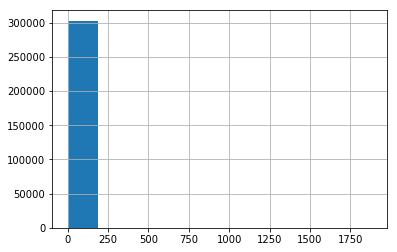

count    302989.000000
mean          2.524927
std           8.472599
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        1884.000000
dtype: float64


In [184]:
counts = pd.Series([v for k,v in counter.items()], index = [k for k,v in counter.items()])
counts.hist()

plt.show()
print(counts.describe())


In [185]:
counts[counts.argsort()[::-1]]
# 5984c6fbb6b113623d63851f
# 'способ производства инстант-порошка из растительного сырья'

5984c6fbb6b113623d63851f    1884
5984c297b6b11331626384f3    1298
5984b582b6b11303ba638525    1280
5984c11bb6b1131e66638511     859
5984b7d5b6b1132953638517     845
5984b97bb6b11340306384fd     797
5984b9fbb6b11348ac63852c     771
5984b808b6b1132b9a638514     700
5984be8bb6b1137ec063851e     694
5984b896b6b113354263853f     614
5984c477b6b113450263854b     591
5984c094b6b11319de638516     548
5984b694b6b113159e638510     529
5984bd8fb6b113730f638548     522
5984b7e9b6b1132a8563850f     518
5984bb4ab6b113587963852a     514
5984c472b6b113450863853a     509
5984c446b6b11343ad638544     501
5984c564b6b113508f638536     486
5984bcd7b6b11368ff63851f     484
5984c477b6b113450263854c     454
5984b960b6b1133ef1638517     445
5984c70bb6b113633c6384f6     431
5984ba88b6b1134d6d63851c     416
5984c711b6b113634963850a     416
5984bc90b6b11366a5638501     401
5984c283b6b1133010638549     382
5984be8bb6b1137ec063851d     377
5984bd80b6b1137302638501     372
5984c4b3b6b11347a2638503     353
          

# Save b560 valid links to mongo

In [198]:
client = MongoClient()
db = client.fips

for k,v in tqdm(res.items()):
    db.patents.update_one({'_id': ObjectId(k)}, {"$set": {'similar':v}}, upsert=False)

100%|██████████| 368458/368458 [07:26<00:00, 825.23it/s] 


# Get w2v

##### tokenize docs and save for fast access

In [2]:
client = MongoClient()
db = client.fips

def json2text(doc):
    text = ''
    if 'name' in doc:
        text += doc['name'] + '.\n'
    if 'abstract' in doc:
        text += doc['abstract'] + '.\n'
    if '"description"' in doc:
        text += doc['description'] + '.\n'
    if 'claims' in doc:
        text += doc['claims']

    return text

In [5]:
# db.patents.update_many({}, {'$unset': {'tokenized':1}})

/home/administrator/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: update is deprecated. Use replace_one, update_one or update_many instead.
  """Entry point for launching an IPython kernel.


{'n': 1266940, 'nModified': 1266940, 'ok': 1, 'updatedExisting': True}

In [67]:
# db.corpus.update_one({'tokenized': 'simple'}, {'$set': {'docs':[]}})

def save_corpus(ids, prefix):
    client = MongoClient()
    db = client.fips
    
    docs = {}
    
    for _id in ids:
        doc_tokenized = []
        
        doc = db.patents.find_one({'_id': _id}, 
                                  {'name': 1, 'abstract': 1, 
                                   'description': 1, 'claims': 1})
        text = json2text(doc)
        for sentence in nltk.sent_tokenize(text):
            tokenized_sent = list(tokenize(sentence, stop_list=simple_stop_list))
            if len(tokenized_sent) > 1:
                doc_tokenized.append(tokenized_sent)
        
        docs[str(_id)] = doc_tokenized
    
    fname = join(DATA_FOLDER, 'documents/%s' % prefix + '.json.gz')
    with GzipFile(fname, 'w') as fout:
        json_str = json.dumps(docs)
        json_bytes = json_str.encode('utf-8')

        fout.write(json_bytes)

In [4]:
docs_ids = [doc['_id'] for doc in db.patents.find({}, {'_id': 1}) ]

In [68]:
parallelizer = Parallel(n_jobs=cpu_count)

# this iterator returns the functions to execute for each task
tasks_iterator = ( delayed(save_corpus)(list_block, i) for 
                  i, list_block in enumerate(grouper(len(docs_ids)//1000, docs_ids)) ) 
result = parallelizer( tasks_iterator )

In [69]:
! echo 'finished json2text' >> ../data/out

##### check

In [73]:
pprint(json2text(db.patents.find_one({'_id': docs_ids[33]})))

('запоминать устройство и способ управление он\n'
 '.\n'
 ' 1. запоминать \n'
 'устройство, содержать размещать на полупроводниковый подложка схема '
 'управление и накопитель на элемент память с изолированный полев \n'
 'электрод и двухслойный подзатворный диэлектрик, \n'
 'отличаться то, что, с цель его упрощение и обеспечение избирательный '
 'стирание, подложка выполнять однородный, а проводимость слой \n'
 'подзатворный диэлектрик удовлетворять соотношение  \n'
 '10σ 1  ≅ σ 2  при e = 0 и  ,  где σ 1  - проводимость диэлектрик, \n'
 'лежать на подложка;  σ 2  - проводимость вышележащий слой диэлектрик;  e - '
 'величина \n'
 'электрический поле.  2. способ управление запоминать \n'
 'устройство, включать подача импульс запись и стирание на полевой электрод '
 'элемент память, отличаться то, что \n'
 'стирание производить импульс тот же, что и при запись, полярность, но '
 'меньший \n'
 'амплитуда, и по меньший мера на порядок большой длительность.\n')


In [77]:
fn = join(DATA_FOLDER, 'documents/0.json.gz')

with GzipFile(fn, 'r') as myzip:
    text = myzip.read()
docs = json.loads(text)
docs[str(docs_ids[33])]


[['запоминать', 'устройство', 'способ', 'управление'],
 ['запоминать',
  'устройство',
  'содержать',
  'размещать',
  'полупроводниковый',
  'подложка',
  'схема',
  'управление',
  'накопитель',
  'элемент',
  'память',
  'изолированный',
  'полев',
  'электрод',
  'двухслойный',
  'подзатворный',
  'диэлектрик',
  'отличаться',
  'цель',
  'упрощение',
  'обеспечение',
  'избирательный',
  'стирание',
  'подложка',
  'выполнять',
  'однородный',
  'проводимость',
  'слой',
  'подзатворный',
  'диэлектрик',
  'удовлетворять',
  'соотношение',
  'проводимость',
  'диэлектрик',
  'лежать',
  'подложка',
  'проводимость',
  'вышележащий',
  'слой',
  'диэлектрик',
  'величина',
  'электрический',
  'поле'],
 ['способ',
  'управление',
  'запоминать',
  'устройство',
  'включать',
  'подача',
  'импульс',
  'запись',
  'стирание',
  'полевой',
  'электрод',
  'элемент',
  'память',
  'отличаться',
  'стирание',
  'производить',
  'импульс',
  'запись',
  'полярность',
  'меньший',
  'амп

In [ ]:
folder = join(DATA_FOLDER, 'documents/')

lens = []

for fn in tqdm(glob(join(folder, '*.gz'))):
    with GzipFile(fn, 'r') as myzip:
        text = myzip.read()
    docs = json.loads(text)
    for k, doc in docs.items():
        l = 0
        for sentence in doc:
            l += len(sentence)
        lens.append((k, l))

  4%|▍         | 41/1001 [00:29<12:12,  1.31it/s]

In [5]:
lenss = pd.Series([v for k,v in lens], index=[k for k,v in lens])

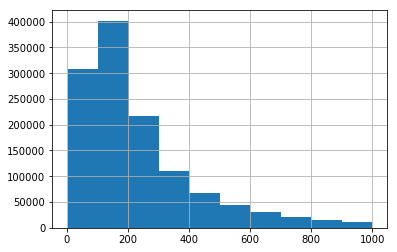

count    1.266867e+06
mean     2.872817e+02
std      4.568104e+02
min      2.000000e+00
25%      1.030000e+02
50%      1.780000e+02
75%      3.190000e+02
max      4.503100e+04
dtype: float64


In [9]:
lenss[lenss<1000].hist()
plt.show()
print(lenss.describe())

##### w2v algo

In [78]:
# iter only over 

class Sentences(object):
    def __init__(self, folder):
        self.folder = folder
 
    def __iter__(self):
        for fn in glob(join(self.folder, '*.gz')):
            with GzipFile(fn, 'r') as myzip:
                text = myzip.read()
            docs = json.loads(text)
            for k, doc in docs.items():
                for sentence in doc:
                    yield sentence

In [ ]:
dim = 300
model = Word2Vec(Sentences(join(DATA_FOLDER, 'documents/')), size=dim, 
                 sg=1, min_count=5, window=10, workers=cpu_count)

2017-08-09 12:39:12,391 : INFO : collecting all words and their counts
2017-08-09 12:39:12,979 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-08-09 12:39:13,066 : INFO : PROGRESS: at sentence #10000, processed 287708 words, keeping 13095 word types
2017-08-09 12:39:13,887 : INFO : PROGRESS: at sentence #20000, processed 577602 words, keeping 18505 word types
2017-08-09 12:39:13,965 : INFO : PROGRESS: at sentence #30000, processed 823044 words, keeping 22039 word types
2017-08-09 12:39:14,046 : INFO : PROGRESS: at sentence #40000, processed 1077793 words, keeping 25644 word types
2017-08-09 12:39:14,927 : INFO : PROGRESS: at sentence #50000, processed 1307043 words, keeping 27726 word types
2017-08-09 12:39:14,990 : INFO : PROGRESS: at sentence #60000, processed 1509061 words, keeping 29752 word types
2017-08-09 12:39:15,060 : INFO : PROGRESS: at sentence #70000, processed 1726629 words, keeping 31632 word types
2017-08-09 12:39:15,505 : INFO : PROGRESS:

2017-08-09 12:39:40,268 : INFO : PROGRESS: at sentence #710000, processed 17798262 words, keeping 128855 word types
2017-08-09 12:39:40,363 : INFO : PROGRESS: at sentence #720000, processed 18082064 words, keeping 129761 word types
2017-08-09 12:39:40,844 : INFO : PROGRESS: at sentence #730000, processed 18350573 words, keeping 130695 word types
2017-08-09 12:39:41,262 : INFO : PROGRESS: at sentence #740000, processed 18597443 words, keeping 131482 word types
2017-08-09 12:39:41,670 : INFO : PROGRESS: at sentence #750000, processed 18863864 words, keeping 132617 word types
2017-08-09 12:39:42,175 : INFO : PROGRESS: at sentence #760000, processed 19127230 words, keeping 133958 word types
2017-08-09 12:39:42,422 : INFO : PROGRESS: at sentence #770000, processed 19353022 words, keeping 134829 word types
2017-08-09 12:39:43,005 : INFO : PROGRESS: at sentence #780000, processed 19554889 words, keeping 135938 word types
2017-08-09 12:39:43,090 : INFO : PROGRESS: at sentence #790000, processe

2017-08-09 12:40:08,477 : INFO : PROGRESS: at sentence #1420000, processed 35753785 words, keeping 187884 word types
2017-08-09 12:40:08,969 : INFO : PROGRESS: at sentence #1430000, processed 35974837 words, keeping 188760 word types
2017-08-09 12:40:09,073 : INFO : PROGRESS: at sentence #1440000, processed 36244012 words, keeping 189098 word types
2017-08-09 12:40:09,576 : INFO : PROGRESS: at sentence #1450000, processed 36519850 words, keeping 189566 word types
2017-08-09 12:40:10,030 : INFO : PROGRESS: at sentence #1460000, processed 36749688 words, keeping 190365 word types
2017-08-09 12:40:10,537 : INFO : PROGRESS: at sentence #1470000, processed 36974467 words, keeping 191493 word types
2017-08-09 12:40:10,634 : INFO : PROGRESS: at sentence #1480000, processed 37246018 words, keeping 191905 word types
2017-08-09 12:40:11,066 : INFO : PROGRESS: at sentence #1490000, processed 37499791 words, keeping 192384 word types
2017-08-09 12:40:11,482 : INFO : PROGRESS: at sentence #1500000,

2017-08-09 12:40:38,411 : INFO : PROGRESS: at sentence #2130000, processed 53963997 words, keeping 231394 word types
2017-08-09 12:40:39,414 : INFO : PROGRESS: at sentence #2140000, processed 54464962 words, keeping 231817 word types
2017-08-09 12:40:39,519 : INFO : PROGRESS: at sentence #2150000, processed 54733401 words, keeping 232186 word types
2017-08-09 12:40:39,622 : INFO : PROGRESS: at sentence #2160000, processed 55012693 words, keeping 232521 word types
2017-08-09 12:40:40,223 : INFO : PROGRESS: at sentence #2170000, processed 55199376 words, keeping 233201 word types
2017-08-09 12:40:40,314 : INFO : PROGRESS: at sentence #2180000, processed 55445054 words, keeping 234005 word types
2017-08-09 12:40:40,940 : INFO : PROGRESS: at sentence #2190000, processed 55759351 words, keeping 234561 word types
2017-08-09 12:40:41,303 : INFO : PROGRESS: at sentence #2200000, processed 56022917 words, keeping 235263 word types
2017-08-09 12:40:42,250 : INFO : PROGRESS: at sentence #2210000,

2017-08-09 12:41:08,857 : INFO : PROGRESS: at sentence #2840000, processed 72609828 words, keeping 266368 word types
2017-08-09 12:41:09,513 : INFO : PROGRESS: at sentence #2850000, processed 72864613 words, keeping 266684 word types
2017-08-09 12:41:09,633 : INFO : PROGRESS: at sentence #2860000, processed 73182611 words, keeping 267123 word types
2017-08-09 12:41:10,116 : INFO : PROGRESS: at sentence #2870000, processed 73450246 words, keeping 267416 word types
2017-08-09 12:41:10,886 : INFO : PROGRESS: at sentence #2880000, processed 73706942 words, keeping 267685 word types
2017-08-09 12:41:10,979 : INFO : PROGRESS: at sentence #2890000, processed 73962643 words, keeping 267925 word types
2017-08-09 12:41:11,567 : INFO : PROGRESS: at sentence #2900000, processed 74213848 words, keeping 268286 word types
2017-08-09 12:41:11,669 : INFO : PROGRESS: at sentence #2910000, processed 74471539 words, keeping 268763 word types
2017-08-09 12:41:12,458 : INFO : PROGRESS: at sentence #2920000,

2017-08-09 12:41:39,270 : INFO : PROGRESS: at sentence #3550000, processed 90767946 words, keeping 301033 word types
2017-08-09 12:41:39,509 : INFO : PROGRESS: at sentence #3560000, processed 90982623 words, keeping 301469 word types
2017-08-09 12:41:39,941 : INFO : PROGRESS: at sentence #3570000, processed 91183931 words, keeping 301922 word types
2017-08-09 12:41:40,268 : INFO : PROGRESS: at sentence #3580000, processed 91436900 words, keeping 302228 word types
2017-08-09 12:41:40,731 : INFO : PROGRESS: at sentence #3590000, processed 91672997 words, keeping 302624 word types
2017-08-09 12:41:41,506 : INFO : PROGRESS: at sentence #3600000, processed 91925828 words, keeping 302892 word types
2017-08-09 12:41:41,601 : INFO : PROGRESS: at sentence #3610000, processed 92150802 words, keeping 303312 word types
2017-08-09 12:41:41,691 : INFO : PROGRESS: at sentence #3620000, processed 92368042 words, keeping 303695 word types
2017-08-09 12:41:42,201 : INFO : PROGRESS: at sentence #3630000,

2017-08-09 12:42:12,439 : INFO : PROGRESS: at sentence #4250000, processed 110187841 words, keeping 337574 word types
2017-08-09 12:42:12,768 : INFO : PROGRESS: at sentence #4260000, processed 110411488 words, keeping 338056 word types
2017-08-09 12:42:13,218 : INFO : PROGRESS: at sentence #4270000, processed 110622316 words, keeping 338616 word types
2017-08-09 12:42:13,322 : INFO : PROGRESS: at sentence #4280000, processed 110862372 words, keeping 339234 word types
2017-08-09 12:42:14,293 : INFO : PROGRESS: at sentence #4290000, processed 111097872 words, keeping 339533 word types
2017-08-09 12:42:14,389 : INFO : PROGRESS: at sentence #4300000, processed 111340516 words, keeping 339725 word types
2017-08-09 12:42:14,806 : INFO : PROGRESS: at sentence #4310000, processed 111609045 words, keeping 340048 word types
2017-08-09 12:42:15,549 : INFO : PROGRESS: at sentence #4320000, processed 111883536 words, keeping 340566 word types
2017-08-09 12:42:15,662 : INFO : PROGRESS: at sentence #

2017-08-09 12:42:43,689 : INFO : PROGRESS: at sentence #4950000, processed 127804120 words, keeping 367241 word types
2017-08-09 12:42:43,773 : INFO : PROGRESS: at sentence #4960000, processed 128019173 words, keeping 367569 word types
2017-08-09 12:42:45,066 : INFO : PROGRESS: at sentence #4970000, processed 128206628 words, keeping 367944 word types
2017-08-09 12:42:45,159 : INFO : PROGRESS: at sentence #4980000, processed 128438283 words, keeping 368143 word types
2017-08-09 12:42:45,253 : INFO : PROGRESS: at sentence #4990000, processed 128676231 words, keeping 368386 word types
2017-08-09 12:42:45,642 : INFO : PROGRESS: at sentence #5000000, processed 128900271 words, keeping 368506 word types
2017-08-09 12:42:46,161 : INFO : PROGRESS: at sentence #5010000, processed 129122343 words, keeping 368994 word types
2017-08-09 12:42:46,275 : INFO : PROGRESS: at sentence #5020000, processed 129376233 words, keeping 369286 word types
2017-08-09 12:42:46,774 : INFO : PROGRESS: at sentence #

2017-08-09 12:43:18,511 : INFO : PROGRESS: at sentence #5650000, processed 147646604 words, keeping 388904 word types
2017-08-09 12:43:19,047 : INFO : PROGRESS: at sentence #5660000, processed 147964305 words, keeping 389080 word types
2017-08-09 12:43:19,460 : INFO : PROGRESS: at sentence #5670000, processed 148237379 words, keeping 389288 word types
2017-08-09 12:43:19,550 : INFO : PROGRESS: at sentence #5680000, processed 148451657 words, keeping 389644 word types
2017-08-09 12:43:20,218 : INFO : PROGRESS: at sentence #5690000, processed 148695182 words, keeping 389980 word types
2017-08-09 12:43:20,797 : INFO : PROGRESS: at sentence #5700000, processed 148957964 words, keeping 390231 word types
2017-08-09 12:43:21,268 : INFO : PROGRESS: at sentence #5710000, processed 149236570 words, keeping 390436 word types
2017-08-09 12:43:21,372 : INFO : PROGRESS: at sentence #5720000, processed 149482075 words, keeping 390700 word types
2017-08-09 12:43:21,805 : INFO : PROGRESS: at sentence #

2017-08-09 12:43:49,544 : INFO : PROGRESS: at sentence #6350000, processed 165581475 words, keeping 411951 word types
2017-08-09 12:43:49,650 : INFO : PROGRESS: at sentence #6360000, processed 165815076 words, keeping 412625 word types
2017-08-09 12:43:50,147 : INFO : PROGRESS: at sentence #6370000, processed 166041488 words, keeping 412959 word types
2017-08-09 12:43:50,706 : INFO : PROGRESS: at sentence #6380000, processed 166265828 words, keeping 413179 word types
2017-08-09 12:43:50,811 : INFO : PROGRESS: at sentence #6390000, processed 166500074 words, keeping 413421 word types
2017-08-09 12:43:51,268 : INFO : PROGRESS: at sentence #6400000, processed 166734621 words, keeping 413620 word types
2017-08-09 12:43:51,769 : INFO : PROGRESS: at sentence #6410000, processed 167024239 words, keeping 414057 word types
2017-08-09 12:43:52,256 : INFO : PROGRESS: at sentence #6420000, processed 167273670 words, keeping 414279 word types
2017-08-09 12:43:52,986 : INFO : PROGRESS: at sentence #

2017-08-09 12:44:20,019 : INFO : PROGRESS: at sentence #7050000, processed 183318578 words, keeping 434133 word types
2017-08-09 12:44:20,476 : INFO : PROGRESS: at sentence #7060000, processed 183564518 words, keeping 434423 word types
2017-08-09 12:44:20,960 : INFO : PROGRESS: at sentence #7070000, processed 183814942 words, keeping 434745 word types
2017-08-09 12:44:21,606 : INFO : PROGRESS: at sentence #7080000, processed 184060813 words, keeping 435106 word types
2017-08-09 12:44:21,727 : INFO : PROGRESS: at sentence #7090000, processed 184338989 words, keeping 435508 word types
2017-08-09 12:44:22,481 : INFO : PROGRESS: at sentence #7100000, processed 184623858 words, keeping 436127 word types
2017-08-09 12:44:22,909 : INFO : PROGRESS: at sentence #7110000, processed 184882753 words, keeping 436501 word types
2017-08-09 12:44:23,219 : INFO : PROGRESS: at sentence #7120000, processed 185120305 words, keeping 436839 word types
2017-08-09 12:44:24,099 : INFO : PROGRESS: at sentence #

2017-08-09 12:44:51,527 : INFO : PROGRESS: at sentence #7750000, processed 201735030 words, keeping 456252 word types
2017-08-09 12:44:51,981 : INFO : PROGRESS: at sentence #7760000, processed 201976517 words, keeping 456529 word types
2017-08-09 12:44:52,778 : INFO : PROGRESS: at sentence #7770000, processed 202208271 words, keeping 456801 word types
2017-08-09 12:44:52,868 : INFO : PROGRESS: at sentence #7780000, processed 202428839 words, keeping 457096 word types
2017-08-09 12:44:52,954 : INFO : PROGRESS: at sentence #7790000, processed 202643105 words, keeping 457246 word types
2017-08-09 12:44:53,640 : INFO : PROGRESS: at sentence #7800000, processed 202896481 words, keeping 457645 word types
2017-08-09 12:44:53,755 : INFO : PROGRESS: at sentence #7810000, processed 203164148 words, keeping 457910 word types
2017-08-09 12:44:54,220 : INFO : PROGRESS: at sentence #7820000, processed 203417739 words, keeping 458049 word types
2017-08-09 12:44:54,655 : INFO : PROGRESS: at sentence #

2017-08-09 12:45:21,436 : INFO : PROGRESS: at sentence #8450000, processed 219272693 words, keeping 476642 word types
2017-08-09 12:45:21,774 : INFO : PROGRESS: at sentence #8460000, processed 219477059 words, keeping 476998 word types
2017-08-09 12:45:22,504 : INFO : PROGRESS: at sentence #8470000, processed 219741756 words, keeping 477493 word types
2017-08-09 12:45:22,615 : INFO : PROGRESS: at sentence #8480000, processed 220005888 words, keeping 477804 word types
2017-08-09 12:45:23,271 : INFO : PROGRESS: at sentence #8490000, processed 220299169 words, keeping 478050 word types
2017-08-09 12:45:23,977 : INFO : PROGRESS: at sentence #8500000, processed 220557974 words, keeping 478332 word types
2017-08-09 12:45:24,083 : INFO : PROGRESS: at sentence #8510000, processed 220826102 words, keeping 478708 word types
2017-08-09 12:45:25,062 : INFO : PROGRESS: at sentence #8520000, processed 221081202 words, keeping 478967 word types
2017-08-09 12:45:25,149 : INFO : PROGRESS: at sentence #

2017-08-09 12:45:51,446 : INFO : PROGRESS: at sentence #9150000, processed 236972752 words, keeping 494162 word types
2017-08-09 12:45:51,952 : INFO : PROGRESS: at sentence #9160000, processed 237240533 words, keeping 494447 word types
2017-08-09 12:45:52,430 : INFO : PROGRESS: at sentence #9170000, processed 237495455 words, keeping 494770 word types
2017-08-09 12:45:52,877 : INFO : PROGRESS: at sentence #9180000, processed 237733771 words, keeping 495132 word types
2017-08-09 12:45:53,339 : INFO : PROGRESS: at sentence #9190000, processed 237962360 words, keeping 495427 word types
2017-08-09 12:45:53,823 : INFO : PROGRESS: at sentence #9200000, processed 238201542 words, keeping 495567 word types
2017-08-09 12:45:53,930 : INFO : PROGRESS: at sentence #9210000, processed 238470599 words, keeping 495799 word types
2017-08-09 12:45:54,861 : INFO : PROGRESS: at sentence #9220000, processed 238681629 words, keeping 496135 word types
2017-08-09 12:45:54,970 : INFO : PROGRESS: at sentence #

2017-08-09 12:46:21,674 : INFO : PROGRESS: at sentence #9850000, processed 254471530 words, keeping 511900 word types
2017-08-09 12:46:22,047 : INFO : PROGRESS: at sentence #9860000, processed 254712907 words, keeping 512165 word types
2017-08-09 12:46:22,502 : INFO : PROGRESS: at sentence #9870000, processed 254960378 words, keeping 512678 word types
2017-08-09 12:46:23,116 : INFO : PROGRESS: at sentence #9880000, processed 255203515 words, keeping 512964 word types
2017-08-09 12:46:23,242 : INFO : PROGRESS: at sentence #9890000, processed 255493888 words, keeping 513189 word types
2017-08-09 12:46:23,684 : INFO : PROGRESS: at sentence #9900000, processed 255721487 words, keeping 513422 word types
2017-08-09 12:46:24,407 : INFO : PROGRESS: at sentence #9910000, processed 256015198 words, keeping 514021 word types
2017-08-09 12:46:24,920 : INFO : PROGRESS: at sentence #9920000, processed 256284008 words, keeping 514258 word types
2017-08-09 12:46:25,041 : INFO : PROGRESS: at sentence #

2017-08-09 12:46:52,112 : INFO : PROGRESS: at sentence #10540000, processed 272360932 words, keeping 532871 word types
2017-08-09 12:46:53,035 : INFO : PROGRESS: at sentence #10550000, processed 272652764 words, keeping 532946 word types
2017-08-09 12:46:53,166 : INFO : PROGRESS: at sentence #10560000, processed 272924308 words, keeping 533028 word types
2017-08-09 12:46:53,313 : INFO : PROGRESS: at sentence #10570000, processed 273187039 words, keeping 533132 word types
2017-08-09 12:46:53,785 : INFO : PROGRESS: at sentence #10580000, processed 273431234 words, keeping 533355 word types
2017-08-09 12:46:54,499 : INFO : PROGRESS: at sentence #10590000, processed 273707380 words, keeping 533655 word types
2017-08-09 12:46:54,626 : INFO : PROGRESS: at sentence #10600000, processed 274014332 words, keeping 534017 word types
2017-08-09 12:46:55,178 : INFO : PROGRESS: at sentence #10610000, processed 274243324 words, keeping 534375 word types
2017-08-09 12:46:55,727 : INFO : PROGRESS: at se

2017-08-09 12:47:22,560 : INFO : PROGRESS: at sentence #11230000, processed 290331317 words, keeping 553219 word types
2017-08-09 12:47:23,164 : INFO : PROGRESS: at sentence #11240000, processed 290600681 words, keeping 553406 word types
2017-08-09 12:47:23,281 : INFO : PROGRESS: at sentence #11250000, processed 290874971 words, keeping 553584 word types
2017-08-09 12:47:23,746 : INFO : PROGRESS: at sentence #11260000, processed 291162326 words, keeping 553901 word types
2017-08-09 12:47:24,258 : INFO : PROGRESS: at sentence #11270000, processed 291410449 words, keeping 554889 word types
2017-08-09 12:47:24,697 : INFO : PROGRESS: at sentence #11280000, processed 291617204 words, keeping 555164 word types
2017-08-09 12:47:25,222 : INFO : PROGRESS: at sentence #11290000, processed 291858714 words, keeping 555307 word types
2017-08-09 12:47:25,357 : INFO : PROGRESS: at sentence #11300000, processed 292103855 words, keeping 555464 word types
2017-08-09 12:47:26,091 : INFO : PROGRESS: at se

2017-08-09 12:47:52,778 : INFO : PROGRESS: at sentence #11920000, processed 308084956 words, keeping 568870 word types
2017-08-09 12:47:53,301 : INFO : PROGRESS: at sentence #11930000, processed 308362765 words, keeping 569026 word types
2017-08-09 12:47:53,796 : INFO : PROGRESS: at sentence #11940000, processed 308632694 words, keeping 569231 word types
2017-08-09 12:47:54,592 : INFO : PROGRESS: at sentence #11950000, processed 308915323 words, keeping 569377 word types
2017-08-09 12:47:54,692 : INFO : PROGRESS: at sentence #11960000, processed 309151186 words, keeping 569453 word types
2017-08-09 12:47:54,970 : INFO : PROGRESS: at sentence #11970000, processed 309391912 words, keeping 569549 word types
2017-08-09 12:47:55,426 : INFO : PROGRESS: at sentence #11980000, processed 309632265 words, keeping 569841 word types
2017-08-09 12:47:55,850 : INFO : PROGRESS: at sentence #11990000, processed 309855363 words, keeping 570089 word types
2017-08-09 12:47:56,446 : INFO : PROGRESS: at se

2017-08-09 12:48:22,760 : INFO : PROGRESS: at sentence #12610000, processed 325511247 words, keeping 584683 word types
2017-08-09 12:48:23,452 : INFO : PROGRESS: at sentence #12620000, processed 325761999 words, keeping 584815 word types
2017-08-09 12:48:23,558 : INFO : PROGRESS: at sentence #12630000, processed 326027569 words, keeping 585086 word types
2017-08-09 12:48:24,098 : INFO : PROGRESS: at sentence #12640000, processed 326273066 words, keeping 585318 word types
2017-08-09 12:48:24,191 : INFO : PROGRESS: at sentence #12650000, processed 326483402 words, keeping 585554 word types
2017-08-09 12:48:24,593 : INFO : PROGRESS: at sentence #12660000, processed 326699610 words, keeping 585864 word types
2017-08-09 12:48:25,326 : INFO : PROGRESS: at sentence #12670000, processed 326909998 words, keeping 586068 word types
2017-08-09 12:48:25,416 : INFO : PROGRESS: at sentence #12680000, processed 327120655 words, keeping 586265 word types
2017-08-09 12:48:25,501 : INFO : PROGRESS: at se

2017-08-09 12:48:52,101 : INFO : PROGRESS: at sentence #13300000, processed 342625752 words, keeping 603182 word types
2017-08-09 12:48:52,752 : INFO : PROGRESS: at sentence #13310000, processed 342840663 words, keeping 603252 word types
2017-08-09 12:48:52,874 : INFO : PROGRESS: at sentence #13320000, processed 343129412 words, keeping 603489 word types
2017-08-09 12:48:53,188 : INFO : PROGRESS: at sentence #13330000, processed 343386184 words, keeping 605437 word types
2017-08-09 12:48:53,647 : INFO : PROGRESS: at sentence #13340000, processed 343602897 words, keeping 607725 word types
2017-08-09 12:48:53,990 : INFO : PROGRESS: at sentence #13350000, processed 343857170 words, keeping 607966 word types
2017-08-09 12:48:54,425 : INFO : PROGRESS: at sentence #13360000, processed 344141298 words, keeping 608147 word types
2017-08-09 12:48:54,948 : INFO : PROGRESS: at sentence #13370000, processed 344383444 words, keeping 608470 word types
2017-08-09 12:48:55,444 : INFO : PROGRESS: at se

2017-08-09 12:49:22,141 : INFO : PROGRESS: at sentence #13990000, processed 360218683 words, keeping 619772 word types
2017-08-09 12:49:22,991 : INFO : PROGRESS: at sentence #14000000, processed 360512046 words, keeping 619920 word types
2017-08-09 12:49:23,122 : INFO : PROGRESS: at sentence #14010000, processed 360799295 words, keeping 620063 word types
2017-08-09 12:49:24,031 : INFO : PROGRESS: at sentence #14020000, processed 361069694 words, keeping 620177 word types
2017-08-09 12:49:24,166 : INFO : PROGRESS: at sentence #14030000, processed 361328889 words, keeping 620237 word types
2017-08-09 12:49:24,830 : INFO : PROGRESS: at sentence #14040000, processed 361580781 words, keeping 620339 word types
2017-08-09 12:49:24,936 : INFO : PROGRESS: at sentence #14050000, processed 361826743 words, keeping 620488 word types
2017-08-09 12:49:25,697 : INFO : PROGRESS: at sentence #14060000, processed 362088970 words, keeping 620726 word types
2017-08-09 12:49:25,780 : INFO : PROGRESS: at se

2017-08-09 12:51:02,206 : INFO : PROGRESS: at 0.68% examples, 132265 words/s, in_qsize 64, out_qsize 0
2017-08-09 12:51:04,137 : INFO : PROGRESS: at 0.69% examples, 131699 words/s, in_qsize 48, out_qsize 11
2017-08-09 12:51:05,174 : INFO : PROGRESS: at 0.70% examples, 133523 words/s, in_qsize 43, out_qsize 0
2017-08-09 12:51:06,711 : INFO : PROGRESS: at 0.71% examples, 131258 words/s, in_qsize 35, out_qsize 16
2017-08-09 12:51:07,792 : INFO : PROGRESS: at 0.72% examples, 132977 words/s, in_qsize 63, out_qsize 0
2017-08-09 12:51:08,829 : INFO : PROGRESS: at 0.73% examples, 133377 words/s, in_qsize 63, out_qsize 0
2017-08-09 12:51:09,874 : INFO : PROGRESS: at 0.74% examples, 134080 words/s, in_qsize 64, out_qsize 0
2017-08-09 12:51:10,928 : INFO : PROGRESS: at 0.75% examples, 134315 words/s, in_qsize 49, out_qsize 1
2017-08-09 12:51:12,037 : INFO : PROGRESS: at 0.76% examples, 135370 words/s, in_qsize 56, out_qsize 0
2017-08-09 12:51:13,153 : INFO : PROGRESS: at 0.76% examples, 134094 wo

2017-08-09 12:52:48,867 : INFO : PROGRESS: at 1.62% examples, 142068 words/s, in_qsize 62, out_qsize 1
2017-08-09 12:52:49,880 : INFO : PROGRESS: at 1.63% examples, 142043 words/s, in_qsize 61, out_qsize 0
2017-08-09 12:52:51,024 : INFO : PROGRESS: at 1.64% examples, 141582 words/s, in_qsize 53, out_qsize 0
2017-08-09 12:52:53,057 : INFO : PROGRESS: at 1.65% examples, 141303 words/s, in_qsize 44, out_qsize 13
2017-08-09 12:52:54,814 : INFO : PROGRESS: at 1.67% examples, 141493 words/s, in_qsize 56, out_qsize 8
2017-08-09 12:52:56,091 : INFO : PROGRESS: at 1.68% examples, 142146 words/s, in_qsize 63, out_qsize 0
2017-08-09 12:52:57,549 : INFO : PROGRESS: at 1.69% examples, 142139 words/s, in_qsize 53, out_qsize 4
2017-08-09 12:52:58,572 : INFO : PROGRESS: at 1.71% examples, 142577 words/s, in_qsize 56, out_qsize 0
2017-08-09 12:52:59,773 : INFO : PROGRESS: at 1.71% examples, 141766 words/s, in_qsize 50, out_qsize 12
2017-08-09 12:53:01,697 : INFO : PROGRESS: at 1.72% examples, 141911 wo

2017-08-09 12:54:34,596 : INFO : PROGRESS: at 2.58% examples, 145343 words/s, in_qsize 63, out_qsize 0
2017-08-09 12:54:35,683 : INFO : PROGRESS: at 2.59% examples, 145363 words/s, in_qsize 55, out_qsize 0
2017-08-09 12:54:36,692 : INFO : PROGRESS: at 2.60% examples, 145184 words/s, in_qsize 44, out_qsize 8
2017-08-09 12:54:38,028 : INFO : PROGRESS: at 2.61% examples, 145242 words/s, in_qsize 63, out_qsize 0
2017-08-09 12:54:39,037 : INFO : PROGRESS: at 2.62% examples, 145062 words/s, in_qsize 57, out_qsize 14
2017-08-09 12:54:40,433 : INFO : PROGRESS: at 2.63% examples, 145339 words/s, in_qsize 57, out_qsize 5
2017-08-09 12:54:41,495 : INFO : PROGRESS: at 2.65% examples, 145716 words/s, in_qsize 64, out_qsize 1
2017-08-09 12:54:43,050 : INFO : PROGRESS: at 2.66% examples, 145684 words/s, in_qsize 43, out_qsize 2
2017-08-09 12:54:45,162 : INFO : PROGRESS: at 2.68% examples, 145684 words/s, in_qsize 63, out_qsize 0
2017-08-09 12:54:46,195 : INFO : PROGRESS: at 2.69% examples, 145865 wor

2017-08-09 12:56:23,848 : INFO : PROGRESS: at 3.48% examples, 146036 words/s, in_qsize 54, out_qsize 1
2017-08-09 12:56:25,474 : INFO : PROGRESS: at 3.50% examples, 146044 words/s, in_qsize 52, out_qsize 10
2017-08-09 12:56:27,703 : INFO : PROGRESS: at 3.52% examples, 145949 words/s, in_qsize 49, out_qsize 4
2017-08-09 12:56:28,847 : INFO : PROGRESS: at 3.54% examples, 146273 words/s, in_qsize 63, out_qsize 0
2017-08-09 12:56:29,863 : INFO : PROGRESS: at 3.54% examples, 146233 words/s, in_qsize 62, out_qsize 1
2017-08-09 12:56:31,414 : INFO : PROGRESS: at 3.55% examples, 146051 words/s, in_qsize 42, out_qsize 11
2017-08-09 12:56:32,463 : INFO : PROGRESS: at 3.57% examples, 146336 words/s, in_qsize 63, out_qsize 0
2017-08-09 12:56:33,865 : INFO : PROGRESS: at 3.57% examples, 145973 words/s, in_qsize 54, out_qsize 18
2017-08-09 12:56:34,877 : INFO : PROGRESS: at 3.59% examples, 146328 words/s, in_qsize 63, out_qsize 0
2017-08-09 12:56:35,878 : INFO : PROGRESS: at 3.60% examples, 146373 w

2017-08-09 12:58:10,028 : INFO : PROGRESS: at 4.51% examples, 149019 words/s, in_qsize 50, out_qsize 14
2017-08-09 12:58:11,624 : INFO : PROGRESS: at 4.52% examples, 149096 words/s, in_qsize 55, out_qsize 8
2017-08-09 12:58:13,302 : INFO : PROGRESS: at 4.54% examples, 149187 words/s, in_qsize 50, out_qsize 1
2017-08-09 12:58:15,137 : INFO : PROGRESS: at 4.56% examples, 149114 words/s, in_qsize 60, out_qsize 1
2017-08-09 12:58:16,890 : INFO : PROGRESS: at 4.57% examples, 149196 words/s, in_qsize 45, out_qsize 5
2017-08-09 12:58:18,102 : INFO : PROGRESS: at 4.59% examples, 149360 words/s, in_qsize 64, out_qsize 0
2017-08-09 12:58:19,159 : INFO : PROGRESS: at 4.60% examples, 149319 words/s, in_qsize 54, out_qsize 6
2017-08-09 12:58:20,163 : INFO : PROGRESS: at 4.61% examples, 149470 words/s, in_qsize 63, out_qsize 0
2017-08-09 12:58:21,203 : INFO : PROGRESS: at 4.63% examples, 149665 words/s, in_qsize 57, out_qsize 0
2017-08-09 12:58:22,370 : INFO : PROGRESS: at 4.63% examples, 149455 wor

2017-08-09 12:59:53,809 : INFO : PROGRESS: at 5.54% examples, 152266 words/s, in_qsize 64, out_qsize 0
2017-08-09 12:59:54,984 : INFO : PROGRESS: at 5.55% examples, 152405 words/s, in_qsize 35, out_qsize 2
2017-08-09 12:59:56,305 : INFO : PROGRESS: at 5.56% examples, 152244 words/s, in_qsize 46, out_qsize 3
2017-08-09 12:59:57,360 : INFO : PROGRESS: at 5.58% examples, 152435 words/s, in_qsize 40, out_qsize 0
2017-08-09 12:59:58,408 : INFO : PROGRESS: at 5.59% examples, 152434 words/s, in_qsize 51, out_qsize 0
2017-08-09 12:59:59,711 : INFO : PROGRESS: at 5.60% examples, 152445 words/s, in_qsize 48, out_qsize 8
2017-08-09 13:00:00,884 : INFO : PROGRESS: at 5.61% examples, 152396 words/s, in_qsize 58, out_qsize 1
2017-08-09 13:00:02,321 : INFO : PROGRESS: at 5.62% examples, 152504 words/s, in_qsize 62, out_qsize 1
2017-08-09 13:00:04,427 : INFO : PROGRESS: at 5.64% examples, 152465 words/s, in_qsize 15, out_qsize 16
2017-08-09 13:00:06,397 : INFO : PROGRESS: at 5.64% examples, 152000 wor

2017-08-09 13:01:37,903 : INFO : PROGRESS: at 6.47% examples, 154288 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:01:39,633 : INFO : PROGRESS: at 6.48% examples, 154138 words/s, in_qsize 58, out_qsize 7
2017-08-09 13:01:41,074 : INFO : PROGRESS: at 6.50% examples, 154244 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:01:42,775 : INFO : PROGRESS: at 6.51% examples, 154072 words/s, in_qsize 55, out_qsize 4
2017-08-09 13:01:43,796 : INFO : PROGRESS: at 6.52% examples, 154271 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:01:44,799 : INFO : PROGRESS: at 6.54% examples, 154364 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:01:46,363 : INFO : PROGRESS: at 6.55% examples, 154212 words/s, in_qsize 55, out_qsize 6
2017-08-09 13:01:47,432 : INFO : PROGRESS: at 6.57% examples, 154393 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:01:48,457 : INFO : PROGRESS: at 6.58% examples, 154494 words/s, in_qsize 46, out_qsize 2
2017-08-09 13:01:49,838 : INFO : PROGRESS: at 6.58% examples, 154305 word

2017-08-09 13:03:28,409 : INFO : PROGRESS: at 7.48% examples, 156540 words/s, in_qsize 58, out_qsize 0
2017-08-09 13:03:29,665 : INFO : PROGRESS: at 7.50% examples, 156652 words/s, in_qsize 54, out_qsize 3
2017-08-09 13:03:30,681 : INFO : PROGRESS: at 7.51% examples, 156741 words/s, in_qsize 64, out_qsize 2
2017-08-09 13:03:31,791 : INFO : PROGRESS: at 7.52% examples, 156675 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:03:33,019 : INFO : PROGRESS: at 7.54% examples, 156788 words/s, in_qsize 40, out_qsize 0
2017-08-09 13:03:34,289 : INFO : PROGRESS: at 7.54% examples, 156583 words/s, in_qsize 34, out_qsize 3
2017-08-09 13:03:35,435 : INFO : PROGRESS: at 7.56% examples, 156724 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:03:36,752 : INFO : PROGRESS: at 7.57% examples, 156665 words/s, in_qsize 42, out_qsize 7
2017-08-09 13:03:38,431 : INFO : PROGRESS: at 7.59% examples, 156693 words/s, in_qsize 60, out_qsize 20
2017-08-09 13:03:39,975 : INFO : PROGRESS: at 7.61% examples, 156757 wor

2017-08-09 13:05:10,755 : INFO : PROGRESS: at 8.56% examples, 159009 words/s, in_qsize 52, out_qsize 8
2017-08-09 13:05:11,956 : INFO : PROGRESS: at 8.58% examples, 159111 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:05:13,145 : INFO : PROGRESS: at 8.59% examples, 159201 words/s, in_qsize 32, out_qsize 5
2017-08-09 13:05:14,803 : INFO : PROGRESS: at 8.61% examples, 159209 words/s, in_qsize 49, out_qsize 12
2017-08-09 13:05:16,773 : INFO : PROGRESS: at 8.63% examples, 159194 words/s, in_qsize 57, out_qsize 12
2017-08-09 13:05:18,054 : INFO : PROGRESS: at 8.66% examples, 159306 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:05:19,230 : INFO : PROGRESS: at 8.67% examples, 159386 words/s, in_qsize 59, out_qsize 0
2017-08-09 13:05:20,309 : INFO : PROGRESS: at 8.69% examples, 159515 words/s, in_qsize 57, out_qsize 0
2017-08-09 13:05:21,568 : INFO : PROGRESS: at 8.69% examples, 159340 words/s, in_qsize 49, out_qsize 4
2017-08-09 13:05:22,786 : INFO : PROGRESS: at 8.71% examples, 159448 wo

2017-08-09 13:06:53,854 : INFO : PROGRESS: at 9.77% examples, 162623 words/s, in_qsize 61, out_qsize 5
2017-08-09 13:06:54,911 : INFO : PROGRESS: at 9.79% examples, 162689 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:06:55,970 : INFO : PROGRESS: at 9.80% examples, 162779 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:06:57,001 : INFO : PROGRESS: at 9.81% examples, 162680 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:06:59,264 : INFO : PROGRESS: at 9.83% examples, 162597 words/s, in_qsize 44, out_qsize 3
2017-08-09 13:07:00,981 : INFO : PROGRESS: at 9.84% examples, 162619 words/s, in_qsize 56, out_qsize 5
2017-08-09 13:07:02,161 : INFO : PROGRESS: at 9.86% examples, 162716 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:07:03,738 : INFO : PROGRESS: at 9.87% examples, 162734 words/s, in_qsize 62, out_qsize 3
2017-08-09 13:07:04,902 : INFO : PROGRESS: at 9.89% examples, 162832 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:07:06,581 : INFO : PROGRESS: at 9.91% examples, 162828 word

2017-08-09 13:08:37,658 : INFO : PROGRESS: at 10.86% examples, 164385 words/s, in_qsize 58, out_qsize 1
2017-08-09 13:08:38,740 : INFO : PROGRESS: at 10.87% examples, 164457 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:08:39,743 : INFO : PROGRESS: at 10.89% examples, 164485 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:08:40,771 : INFO : PROGRESS: at 10.90% examples, 164453 words/s, in_qsize 64, out_qsize 1
2017-08-09 13:08:41,805 : INFO : PROGRESS: at 10.91% examples, 164542 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:08:42,895 : INFO : PROGRESS: at 10.92% examples, 164467 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:08:44,077 : INFO : PROGRESS: at 10.93% examples, 164494 words/s, in_qsize 46, out_qsize 1
2017-08-09 13:08:45,699 : INFO : PROGRESS: at 10.94% examples, 164490 words/s, in_qsize 41, out_qsize 9
2017-08-09 13:08:46,934 : INFO : PROGRESS: at 10.96% examples, 164541 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:08:48,433 : INFO : PROGRESS: at 10.97% examples, 1

2017-08-09 13:10:17,756 : INFO : PROGRESS: at 11.95% examples, 165717 words/s, in_qsize 55, out_qsize 22
2017-08-09 13:10:19,546 : INFO : PROGRESS: at 11.97% examples, 165728 words/s, in_qsize 53, out_qsize 10
2017-08-09 13:10:20,616 : INFO : PROGRESS: at 11.99% examples, 165823 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:10:21,627 : INFO : PROGRESS: at 12.00% examples, 165873 words/s, in_qsize 55, out_qsize 1
2017-08-09 13:10:23,135 : INFO : PROGRESS: at 12.01% examples, 165738 words/s, in_qsize 39, out_qsize 13
2017-08-09 13:10:24,396 : INFO : PROGRESS: at 12.02% examples, 165805 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:10:25,662 : INFO : PROGRESS: at 12.04% examples, 165866 words/s, in_qsize 58, out_qsize 0
2017-08-09 13:10:26,736 : INFO : PROGRESS: at 12.05% examples, 165886 words/s, in_qsize 55, out_qsize 1
2017-08-09 13:10:28,166 : INFO : PROGRESS: at 12.07% examples, 165895 words/s, in_qsize 56, out_qsize 2
2017-08-09 13:10:29,682 : INFO : PROGRESS: at 12.08% examples

2017-08-09 13:11:59,524 : INFO : PROGRESS: at 13.08% examples, 167196 words/s, in_qsize 56, out_qsize 4
2017-08-09 13:12:01,622 : INFO : PROGRESS: at 13.10% examples, 167149 words/s, in_qsize 49, out_qsize 10
2017-08-09 13:12:02,795 : INFO : PROGRESS: at 13.12% examples, 167226 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:12:04,832 : INFO : PROGRESS: at 13.14% examples, 167194 words/s, in_qsize 44, out_qsize 5
2017-08-09 13:12:05,872 : INFO : PROGRESS: at 13.15% examples, 167282 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:12:06,884 : INFO : PROGRESS: at 13.17% examples, 167316 words/s, in_qsize 62, out_qsize 0
2017-08-09 13:12:07,891 : INFO : PROGRESS: at 13.18% examples, 167295 words/s, in_qsize 53, out_qsize 9
2017-08-09 13:12:09,376 : INFO : PROGRESS: at 13.20% examples, 167302 words/s, in_qsize 60, out_qsize 3
2017-08-09 13:12:10,515 : INFO : PROGRESS: at 13.22% examples, 167380 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:12:11,523 : INFO : PROGRESS: at 13.23% examples, 

2017-08-09 13:13:38,554 : INFO : PROGRESS: at 14.20% examples, 168581 words/s, in_qsize 40, out_qsize 14
2017-08-09 13:13:39,578 : INFO : PROGRESS: at 14.22% examples, 168668 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:13:40,594 : INFO : PROGRESS: at 14.23% examples, 168736 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:13:42,379 : INFO : PROGRESS: at 14.24% examples, 168624 words/s, in_qsize 62, out_qsize 4
2017-08-09 13:13:43,555 : INFO : PROGRESS: at 14.26% examples, 168692 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:13:44,638 : INFO : PROGRESS: at 14.28% examples, 168769 words/s, in_qsize 46, out_qsize 0
2017-08-09 13:13:45,639 : INFO : PROGRESS: at 14.29% examples, 168809 words/s, in_qsize 59, out_qsize 0
2017-08-09 13:13:46,651 : INFO : PROGRESS: at 14.30% examples, 168789 words/s, in_qsize 62, out_qsize 1
2017-08-09 13:13:47,890 : INFO : PROGRESS: at 14.31% examples, 168810 words/s, in_qsize 64, out_qsize 4
2017-08-09 13:13:48,897 : INFO : PROGRESS: at 14.32% examples, 

2017-08-09 13:15:16,401 : INFO : PROGRESS: at 15.28% examples, 169983 words/s, in_qsize 63, out_qsize 9
2017-08-09 13:15:17,460 : INFO : PROGRESS: at 15.30% examples, 170054 words/s, in_qsize 55, out_qsize 3
2017-08-09 13:15:19,074 : INFO : PROGRESS: at 15.32% examples, 170060 words/s, in_qsize 51, out_qsize 14
2017-08-09 13:15:21,041 : INFO : PROGRESS: at 15.34% examples, 170034 words/s, in_qsize 49, out_qsize 18
2017-08-09 13:15:22,053 : INFO : PROGRESS: at 15.36% examples, 170117 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:15:23,185 : INFO : PROGRESS: at 15.38% examples, 170173 words/s, in_qsize 39, out_qsize 0
2017-08-09 13:15:24,203 : INFO : PROGRESS: at 15.38% examples, 170079 words/s, in_qsize 35, out_qsize 7
2017-08-09 13:15:25,775 : INFO : PROGRESS: at 15.39% examples, 170079 words/s, in_qsize 60, out_qsize 0
2017-08-09 13:15:27,298 : INFO : PROGRESS: at 15.41% examples, 170101 words/s, in_qsize 47, out_qsize 10
2017-08-09 13:15:28,316 : INFO : PROGRESS: at 15.42% examples

2017-08-09 13:16:57,842 : INFO : PROGRESS: at 16.40% examples, 171126 words/s, in_qsize 60, out_qsize 0
2017-08-09 13:16:59,321 : INFO : PROGRESS: at 16.41% examples, 171046 words/s, in_qsize 51, out_qsize 9
2017-08-09 13:17:00,666 : INFO : PROGRESS: at 16.43% examples, 171077 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:17:01,710 : INFO : PROGRESS: at 16.44% examples, 171106 words/s, in_qsize 46, out_qsize 4
2017-08-09 13:17:03,438 : INFO : PROGRESS: at 16.46% examples, 171082 words/s, in_qsize 47, out_qsize 5
2017-08-09 13:17:04,988 : INFO : PROGRESS: at 16.47% examples, 171085 words/s, in_qsize 42, out_qsize 12
2017-08-09 13:17:06,199 : INFO : PROGRESS: at 16.49% examples, 171124 words/s, in_qsize 63, out_qsize 3
2017-08-09 13:17:07,311 : INFO : PROGRESS: at 16.51% examples, 171174 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:17:08,347 : INFO : PROGRESS: at 16.52% examples, 171197 words/s, in_qsize 57, out_qsize 0
2017-08-09 13:17:09,385 : INFO : PROGRESS: at 16.53% examples, 

2017-08-09 13:18:34,202 : INFO : PROGRESS: at 17.46% examples, 171838 words/s, in_qsize 52, out_qsize 2
2017-08-09 13:18:35,687 : INFO : PROGRESS: at 17.47% examples, 171820 words/s, in_qsize 49, out_qsize 3
2017-08-09 13:18:37,397 : INFO : PROGRESS: at 17.49% examples, 171830 words/s, in_qsize 57, out_qsize 3
2017-08-09 13:18:38,598 : INFO : PROGRESS: at 17.51% examples, 171885 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:18:39,623 : INFO : PROGRESS: at 17.53% examples, 171942 words/s, in_qsize 35, out_qsize 1
2017-08-09 13:18:40,938 : INFO : PROGRESS: at 17.53% examples, 171839 words/s, in_qsize 22, out_qsize 13
2017-08-09 13:18:42,115 : INFO : PROGRESS: at 17.55% examples, 171893 words/s, in_qsize 61, out_qsize 0
2017-08-09 13:18:43,217 : INFO : PROGRESS: at 17.57% examples, 171939 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:18:44,233 : INFO : PROGRESS: at 17.58% examples, 171971 words/s, in_qsize 62, out_qsize 0
2017-08-09 13:18:45,875 : INFO : PROGRESS: at 17.59% examples, 

2017-08-09 13:20:12,901 : INFO : PROGRESS: at 18.57% examples, 172543 words/s, in_qsize 57, out_qsize 4
2017-08-09 13:20:13,903 : INFO : PROGRESS: at 18.58% examples, 172582 words/s, in_qsize 46, out_qsize 0
2017-08-09 13:20:15,353 : INFO : PROGRESS: at 18.60% examples, 172559 words/s, in_qsize 50, out_qsize 5
2017-08-09 13:20:16,368 : INFO : PROGRESS: at 18.61% examples, 172621 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:20:17,426 : INFO : PROGRESS: at 18.62% examples, 172623 words/s, in_qsize 62, out_qsize 1
2017-08-09 13:20:18,460 : INFO : PROGRESS: at 18.63% examples, 172609 words/s, in_qsize 59, out_qsize 3
2017-08-09 13:20:20,192 : INFO : PROGRESS: at 18.65% examples, 172589 words/s, in_qsize 53, out_qsize 8
2017-08-09 13:20:21,470 : INFO : PROGRESS: at 18.67% examples, 172620 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:20:23,044 : INFO : PROGRESS: at 18.68% examples, 172603 words/s, in_qsize 35, out_qsize 12
2017-08-09 13:20:24,566 : INFO : PROGRESS: at 18.70% examples, 

2017-08-09 13:21:53,894 : INFO : PROGRESS: at 19.66% examples, 173084 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:21:55,162 : INFO : PROGRESS: at 19.67% examples, 173028 words/s, in_qsize 45, out_qsize 11
2017-08-09 13:21:56,291 : INFO : PROGRESS: at 19.69% examples, 173081 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:21:57,908 : INFO : PROGRESS: at 19.70% examples, 173041 words/s, in_qsize 36, out_qsize 9
2017-08-09 13:21:58,972 : INFO : PROGRESS: at 19.71% examples, 173093 words/s, in_qsize 62, out_qsize 0
2017-08-09 13:21:59,985 : INFO : PROGRESS: at 19.72% examples, 173031 words/s, in_qsize 59, out_qsize 4
2017-08-09 13:22:01,281 : INFO : PROGRESS: at 19.74% examples, 173057 words/s, in_qsize 62, out_qsize 1
2017-08-09 13:22:02,311 : INFO : PROGRESS: at 19.76% examples, 173108 words/s, in_qsize 62, out_qsize 0
2017-08-09 13:22:03,552 : INFO : PROGRESS: at 19.76% examples, 173035 words/s, in_qsize 44, out_qsize 16
2017-08-09 13:22:04,659 : INFO : PROGRESS: at 19.78% examples,

2017-08-09 13:23:32,323 : INFO : PROGRESS: at 20.76% examples, 173626 words/s, in_qsize 62, out_qsize 1
2017-08-09 13:23:33,748 : INFO : PROGRESS: at 20.77% examples, 173617 words/s, in_qsize 52, out_qsize 2
2017-08-09 13:23:35,229 : INFO : PROGRESS: at 20.78% examples, 173633 words/s, in_qsize 63, out_qsize 6
2017-08-09 13:23:36,820 : INFO : PROGRESS: at 20.80% examples, 173636 words/s, in_qsize 61, out_qsize 3
2017-08-09 13:23:38,314 : INFO : PROGRESS: at 20.82% examples, 173656 words/s, in_qsize 63, out_qsize 2
2017-08-09 13:23:39,381 : INFO : PROGRESS: at 20.84% examples, 173709 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:23:40,416 : INFO : PROGRESS: at 20.86% examples, 173758 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:23:41,452 : INFO : PROGRESS: at 20.86% examples, 173694 words/s, in_qsize 64, out_qsize 1
2017-08-09 13:23:42,442 : INFO : PROGRESS: at 20.88% examples, 173727 words/s, in_qsize 54, out_qsize 4
2017-08-09 13:23:44,279 : INFO : PROGRESS: at 20.89% examples, 1

2017-08-09 13:25:13,798 : INFO : PROGRESS: at 21.88% examples, 174189 words/s, in_qsize 62, out_qsize 0
2017-08-09 13:25:14,958 : INFO : PROGRESS: at 21.89% examples, 174180 words/s, in_qsize 54, out_qsize 2
2017-08-09 13:25:16,071 : INFO : PROGRESS: at 21.89% examples, 174094 words/s, in_qsize 64, out_qsize 29
2017-08-09 13:25:17,280 : INFO : PROGRESS: at 21.90% examples, 174144 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:25:19,189 : INFO : PROGRESS: at 21.92% examples, 174120 words/s, in_qsize 47, out_qsize 13
2017-08-09 13:25:20,390 : INFO : PROGRESS: at 21.95% examples, 174168 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:25:21,403 : INFO : PROGRESS: at 21.97% examples, 174224 words/s, in_qsize 59, out_qsize 0
2017-08-09 13:25:22,515 : INFO : PROGRESS: at 21.98% examples, 174185 words/s, in_qsize 44, out_qsize 3
2017-08-09 13:25:23,810 : INFO : PROGRESS: at 21.99% examples, 174209 words/s, in_qsize 52, out_qsize 2
2017-08-09 13:25:25,235 : INFO : PROGRESS: at 22.01% examples,

2017-08-09 13:26:57,096 : INFO : PROGRESS: at 23.01% examples, 174619 words/s, in_qsize 22, out_qsize 21
2017-08-09 13:26:58,102 : INFO : PROGRESS: at 23.02% examples, 174674 words/s, in_qsize 62, out_qsize 0
2017-08-09 13:26:59,486 : INFO : PROGRESS: at 23.02% examples, 174635 words/s, in_qsize 55, out_qsize 14
2017-08-09 13:27:01,079 : INFO : PROGRESS: at 23.03% examples, 174644 words/s, in_qsize 53, out_qsize 9
2017-08-09 13:27:02,093 : INFO : PROGRESS: at 23.05% examples, 174696 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:27:03,153 : INFO : PROGRESS: at 23.07% examples, 174714 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:27:04,614 : INFO : PROGRESS: at 23.07% examples, 174663 words/s, in_qsize 50, out_qsize 2
2017-08-09 13:27:05,714 : INFO : PROGRESS: at 23.09% examples, 174710 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:27:06,719 : INFO : PROGRESS: at 23.11% examples, 174754 words/s, in_qsize 57, out_qsize 0
2017-08-09 13:27:07,743 : INFO : PROGRESS: at 23.11% examples,

2017-08-09 13:28:34,704 : INFO : PROGRESS: at 24.06% examples, 175205 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:28:36,282 : INFO : PROGRESS: at 24.07% examples, 175123 words/s, in_qsize 57, out_qsize 6
2017-08-09 13:28:37,433 : INFO : PROGRESS: at 24.09% examples, 175172 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:28:39,239 : INFO : PROGRESS: at 24.10% examples, 175111 words/s, in_qsize 55, out_qsize 8
2017-08-09 13:28:40,366 : INFO : PROGRESS: at 24.11% examples, 175158 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:28:41,692 : INFO : PROGRESS: at 24.13% examples, 175158 words/s, in_qsize 39, out_qsize 8
2017-08-09 13:28:42,789 : INFO : PROGRESS: at 24.14% examples, 175182 words/s, in_qsize 48, out_qsize 3
2017-08-09 13:28:44,163 : INFO : PROGRESS: at 24.15% examples, 175198 words/s, in_qsize 55, out_qsize 2
2017-08-09 13:28:45,313 : INFO : PROGRESS: at 24.17% examples, 175211 words/s, in_qsize 49, out_qsize 3
2017-08-09 13:28:47,261 : INFO : PROGRESS: at 24.18% examples, 1

2017-08-09 13:30:16,417 : INFO : PROGRESS: at 25.19% examples, 175609 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:30:17,432 : INFO : PROGRESS: at 25.21% examples, 175629 words/s, in_qsize 57, out_qsize 0
2017-08-09 13:30:18,741 : INFO : PROGRESS: at 25.22% examples, 175656 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:30:19,752 : INFO : PROGRESS: at 25.23% examples, 175681 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:30:20,956 : INFO : PROGRESS: at 25.24% examples, 175631 words/s, in_qsize 45, out_qsize 8
2017-08-09 13:30:21,994 : INFO : PROGRESS: at 25.25% examples, 175644 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:30:23,048 : INFO : PROGRESS: at 25.26% examples, 175660 words/s, in_qsize 61, out_qsize 0
2017-08-09 13:30:24,181 : INFO : PROGRESS: at 25.28% examples, 175703 words/s, in_qsize 59, out_qsize 0
2017-08-09 13:30:25,342 : INFO : PROGRESS: at 25.28% examples, 175627 words/s, in_qsize 52, out_qsize 9
2017-08-09 13:30:26,396 : INFO : PROGRESS: at 25.30% examples, 1

2017-08-09 13:31:53,642 : INFO : PROGRESS: at 26.21% examples, 176315 words/s, in_qsize 52, out_qsize 0
2017-08-09 13:31:55,106 : INFO : PROGRESS: at 26.22% examples, 176261 words/s, in_qsize 28, out_qsize 11
2017-08-09 13:31:56,129 : INFO : PROGRESS: at 26.24% examples, 176292 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:31:57,194 : INFO : PROGRESS: at 26.25% examples, 176316 words/s, in_qsize 48, out_qsize 0
2017-08-09 13:31:58,239 : INFO : PROGRESS: at 26.26% examples, 176331 words/s, in_qsize 52, out_qsize 1
2017-08-09 13:31:59,252 : INFO : PROGRESS: at 26.27% examples, 176327 words/s, in_qsize 62, out_qsize 1
2017-08-09 13:32:01,398 : INFO : PROGRESS: at 26.28% examples, 176250 words/s, in_qsize 56, out_qsize 15
2017-08-09 13:32:02,612 : INFO : PROGRESS: at 26.30% examples, 176283 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:32:04,103 : INFO : PROGRESS: at 26.32% examples, 176285 words/s, in_qsize 61, out_qsize 4
2017-08-09 13:32:05,300 : INFO : PROGRESS: at 26.33% examples,

2017-08-09 13:33:37,386 : INFO : PROGRESS: at 27.39% examples, 176972 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:33:38,439 : INFO : PROGRESS: at 27.39% examples, 177009 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:33:39,498 : INFO : PROGRESS: at 27.39% examples, 177051 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:33:40,545 : INFO : PROGRESS: at 27.39% examples, 177097 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:33:41,940 : INFO : PROGRESS: at 27.39% examples, 177072 words/s, in_qsize 43, out_qsize 9
2017-08-09 13:33:43,149 : INFO : PROGRESS: at 27.39% examples, 177105 words/s, in_qsize 58, out_qsize 1
2017-08-09 13:33:44,167 : INFO : PROGRESS: at 27.39% examples, 177159 words/s, in_qsize 55, out_qsize 0
2017-08-09 13:33:45,340 : INFO : PROGRESS: at 27.40% examples, 177123 words/s, in_qsize 53, out_qsize 21
2017-08-09 13:33:46,903 : INFO : PROGRESS: at 27.41% examples, 177129 words/s, in_qsize 42, out_qsize 13
2017-08-09 13:33:47,961 : INFO : PROGRESS: at 27.43% examples,

2017-08-09 13:35:16,070 : INFO : PROGRESS: at 28.49% examples, 177979 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:35:17,077 : INFO : PROGRESS: at 28.50% examples, 178015 words/s, in_qsize 54, out_qsize 0
2017-08-09 13:35:18,110 : INFO : PROGRESS: at 28.52% examples, 178019 words/s, in_qsize 57, out_qsize 0
2017-08-09 13:35:19,112 : INFO : PROGRESS: at 28.53% examples, 178024 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:35:20,273 : INFO : PROGRESS: at 28.53% examples, 178009 words/s, in_qsize 61, out_qsize 4
2017-08-09 13:35:21,471 : INFO : PROGRESS: at 28.55% examples, 178038 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:35:22,503 : INFO : PROGRESS: at 28.57% examples, 178077 words/s, in_qsize 56, out_qsize 0
2017-08-09 13:35:23,511 : INFO : PROGRESS: at 28.58% examples, 178076 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:35:25,394 : INFO : PROGRESS: at 28.58% examples, 178015 words/s, in_qsize 51, out_qsize 5
2017-08-09 13:35:27,110 : INFO : PROGRESS: at 28.60% examples, 1

2017-08-09 13:36:51,242 : INFO : PROGRESS: at 29.61% examples, 178657 words/s, in_qsize 44, out_qsize 4
2017-08-09 13:36:52,352 : INFO : PROGRESS: at 29.63% examples, 178687 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:36:53,467 : INFO : PROGRESS: at 29.64% examples, 178676 words/s, in_qsize 47, out_qsize 5
2017-08-09 13:36:54,842 : INFO : PROGRESS: at 29.65% examples, 178688 words/s, in_qsize 60, out_qsize 8
2017-08-09 13:36:55,877 : INFO : PROGRESS: at 29.67% examples, 178692 words/s, in_qsize 63, out_qsize 7
2017-08-09 13:36:57,009 : INFO : PROGRESS: at 29.68% examples, 178721 words/s, in_qsize 62, out_qsize 1
2017-08-09 13:36:58,699 : INFO : PROGRESS: at 29.70% examples, 178696 words/s, in_qsize 44, out_qsize 11
2017-08-09 13:36:59,818 : INFO : PROGRESS: at 29.72% examples, 178717 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:37:00,940 : INFO : PROGRESS: at 29.73% examples, 178719 words/s, in_qsize 53, out_qsize 1
2017-08-09 13:37:02,040 : INFO : PROGRESS: at 29.73% examples, 

2017-08-09 13:38:27,723 : INFO : PROGRESS: at 30.73% examples, 179341 words/s, in_qsize 49, out_qsize 7
2017-08-09 13:38:28,889 : INFO : PROGRESS: at 30.74% examples, 179374 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:38:29,973 : INFO : PROGRESS: at 30.76% examples, 179411 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:38:31,194 : INFO : PROGRESS: at 30.77% examples, 179362 words/s, in_qsize 49, out_qsize 10
2017-08-09 13:38:32,415 : INFO : PROGRESS: at 30.78% examples, 179389 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:38:34,255 : INFO : PROGRESS: at 30.80% examples, 179375 words/s, in_qsize 31, out_qsize 14
2017-08-09 13:38:35,440 : INFO : PROGRESS: at 30.82% examples, 179401 words/s, in_qsize 55, out_qsize 0
2017-08-09 13:38:36,813 : INFO : PROGRESS: at 30.84% examples, 179414 words/s, in_qsize 44, out_qsize 5
2017-08-09 13:38:37,937 : INFO : PROGRESS: at 30.85% examples, 179443 words/s, in_qsize 45, out_qsize 0
2017-08-09 13:38:39,622 : INFO : PROGRESS: at 30.87% examples,

2017-08-09 13:40:10,924 : INFO : PROGRESS: at 31.95% examples, 179977 words/s, in_qsize 37, out_qsize 11
2017-08-09 13:40:12,525 : INFO : PROGRESS: at 31.97% examples, 179981 words/s, in_qsize 57, out_qsize 8
2017-08-09 13:40:13,672 : INFO : PROGRESS: at 31.99% examples, 180014 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:40:15,573 : INFO : PROGRESS: at 32.00% examples, 179983 words/s, in_qsize 44, out_qsize 6
2017-08-09 13:40:16,597 : INFO : PROGRESS: at 32.02% examples, 180021 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:40:18,437 : INFO : PROGRESS: at 32.04% examples, 180003 words/s, in_qsize 47, out_qsize 16
2017-08-09 13:40:19,563 : INFO : PROGRESS: at 32.05% examples, 180033 words/s, in_qsize 49, out_qsize 0
2017-08-09 13:40:20,714 : INFO : PROGRESS: at 32.07% examples, 180047 words/s, in_qsize 55, out_qsize 3
2017-08-09 13:40:22,205 : INFO : PROGRESS: at 32.09% examples, 180047 words/s, in_qsize 54, out_qsize 0
2017-08-09 13:40:23,748 : INFO : PROGRESS: at 32.11% examples,

2017-08-09 13:41:53,783 : INFO : PROGRESS: at 33.18% examples, 180564 words/s, in_qsize 46, out_qsize 0
2017-08-09 13:41:55,171 : INFO : PROGRESS: at 33.20% examples, 180578 words/s, in_qsize 56, out_qsize 2
2017-08-09 13:41:56,341 : INFO : PROGRESS: at 33.22% examples, 180605 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:41:57,673 : INFO : PROGRESS: at 33.23% examples, 180599 words/s, in_qsize 45, out_qsize 0
2017-08-09 13:41:58,956 : INFO : PROGRESS: at 33.25% examples, 180613 words/s, in_qsize 43, out_qsize 3
2017-08-09 13:42:00,001 : INFO : PROGRESS: at 33.26% examples, 180634 words/s, in_qsize 56, out_qsize 0
2017-08-09 13:42:01,296 : INFO : PROGRESS: at 33.28% examples, 180647 words/s, in_qsize 60, out_qsize 2
2017-08-09 13:42:02,901 : INFO : PROGRESS: at 33.28% examples, 180597 words/s, in_qsize 38, out_qsize 15
2017-08-09 13:42:03,957 : INFO : PROGRESS: at 33.30% examples, 180619 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:42:04,992 : INFO : PROGRESS: at 33.31% examples, 

2017-08-09 13:43:33,645 : INFO : PROGRESS: at 34.35% examples, 181055 words/s, in_qsize 64, out_qsize 1
2017-08-09 13:43:35,006 : INFO : PROGRESS: at 34.37% examples, 181067 words/s, in_qsize 48, out_qsize 0
2017-08-09 13:43:36,545 : INFO : PROGRESS: at 34.39% examples, 181062 words/s, in_qsize 44, out_qsize 4
2017-08-09 13:43:38,106 : INFO : PROGRESS: at 34.41% examples, 181065 words/s, in_qsize 53, out_qsize 11
2017-08-09 13:43:39,253 : INFO : PROGRESS: at 34.42% examples, 181092 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:43:40,648 : INFO : PROGRESS: at 34.43% examples, 181069 words/s, in_qsize 40, out_qsize 6
2017-08-09 13:43:41,735 : INFO : PROGRESS: at 34.45% examples, 181095 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:43:42,755 : INFO : PROGRESS: at 34.46% examples, 181109 words/s, in_qsize 55, out_qsize 0
2017-08-09 13:43:43,886 : INFO : PROGRESS: at 34.47% examples, 181075 words/s, in_qsize 38, out_qsize 9
2017-08-09 13:43:45,004 : INFO : PROGRESS: at 34.48% examples, 

2017-08-09 13:45:16,657 : INFO : PROGRESS: at 35.53% examples, 181487 words/s, in_qsize 50, out_qsize 1
2017-08-09 13:45:17,676 : INFO : PROGRESS: at 35.53% examples, 181451 words/s, in_qsize 32, out_qsize 12
2017-08-09 13:45:19,084 : INFO : PROGRESS: at 35.55% examples, 181454 words/s, in_qsize 60, out_qsize 2
2017-08-09 13:45:20,132 : INFO : PROGRESS: at 35.56% examples, 181486 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:45:21,146 : INFO : PROGRESS: at 35.57% examples, 181483 words/s, in_qsize 62, out_qsize 0
2017-08-09 13:45:22,329 : INFO : PROGRESS: at 35.58% examples, 181455 words/s, in_qsize 44, out_qsize 5
2017-08-09 13:45:23,357 : INFO : PROGRESS: at 35.60% examples, 181483 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:45:24,484 : INFO : PROGRESS: at 35.61% examples, 181506 words/s, in_qsize 39, out_qsize 0
2017-08-09 13:45:25,510 : INFO : PROGRESS: at 35.63% examples, 181525 words/s, in_qsize 59, out_qsize 0
2017-08-09 13:45:26,528 : INFO : PROGRESS: at 35.63% examples, 

2017-08-09 13:46:55,236 : INFO : PROGRESS: at 36.65% examples, 181868 words/s, in_qsize 52, out_qsize 8
2017-08-09 13:46:56,335 : INFO : PROGRESS: at 36.67% examples, 181896 words/s, in_qsize 62, out_qsize 1
2017-08-09 13:46:57,345 : INFO : PROGRESS: at 36.69% examples, 181924 words/s, in_qsize 44, out_qsize 0
2017-08-09 13:46:58,389 : INFO : PROGRESS: at 36.70% examples, 181927 words/s, in_qsize 57, out_qsize 0
2017-08-09 13:46:59,422 : INFO : PROGRESS: at 36.70% examples, 181911 words/s, in_qsize 59, out_qsize 4
2017-08-09 13:47:00,435 : INFO : PROGRESS: at 36.72% examples, 181924 words/s, in_qsize 47, out_qsize 3
2017-08-09 13:47:01,687 : INFO : PROGRESS: at 36.73% examples, 181907 words/s, in_qsize 56, out_qsize 0
2017-08-09 13:47:03,118 : INFO : PROGRESS: at 36.74% examples, 181907 words/s, in_qsize 50, out_qsize 7
2017-08-09 13:47:04,766 : INFO : PROGRESS: at 36.76% examples, 181907 words/s, in_qsize 54, out_qsize 8
2017-08-09 13:47:06,394 : INFO : PROGRESS: at 36.78% examples, 1

2017-08-09 13:48:35,569 : INFO : PROGRESS: at 37.81% examples, 182233 words/s, in_qsize 29, out_qsize 12
2017-08-09 13:48:36,805 : INFO : PROGRESS: at 37.83% examples, 182243 words/s, in_qsize 55, out_qsize 8
2017-08-09 13:48:37,961 : INFO : PROGRESS: at 37.84% examples, 182267 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:48:39,115 : INFO : PROGRESS: at 37.86% examples, 182287 words/s, in_qsize 57, out_qsize 0
2017-08-09 13:48:40,278 : INFO : PROGRESS: at 37.86% examples, 182235 words/s, in_qsize 48, out_qsize 11
2017-08-09 13:48:41,475 : INFO : PROGRESS: at 37.88% examples, 182254 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:48:42,521 : INFO : PROGRESS: at 37.90% examples, 182279 words/s, in_qsize 49, out_qsize 0
2017-08-09 13:48:43,541 : INFO : PROGRESS: at 37.92% examples, 182303 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:48:44,575 : INFO : PROGRESS: at 37.92% examples, 182268 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:48:46,092 : INFO : PROGRESS: at 37.94% examples,

2017-08-09 13:50:16,438 : INFO : PROGRESS: at 39.01% examples, 182610 words/s, in_qsize 61, out_qsize 0
2017-08-09 13:50:17,912 : INFO : PROGRESS: at 39.01% examples, 182549 words/s, in_qsize 35, out_qsize 27
2017-08-09 13:50:19,000 : INFO : PROGRESS: at 39.03% examples, 182579 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:50:20,312 : INFO : PROGRESS: at 39.04% examples, 182582 words/s, in_qsize 48, out_qsize 3
2017-08-09 13:50:21,356 : INFO : PROGRESS: at 39.06% examples, 182603 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:50:22,662 : INFO : PROGRESS: at 39.07% examples, 182591 words/s, in_qsize 50, out_qsize 10
2017-08-09 13:50:23,963 : INFO : PROGRESS: at 39.09% examples, 182602 words/s, in_qsize 54, out_qsize 0
2017-08-09 13:50:25,438 : INFO : PROGRESS: at 39.11% examples, 182607 words/s, in_qsize 62, out_qsize 11
2017-08-09 13:50:26,521 : INFO : PROGRESS: at 39.13% examples, 182636 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:50:28,106 : INFO : PROGRESS: at 39.14% examples

2017-08-09 13:51:55,901 : INFO : PROGRESS: at 40.15% examples, 182865 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:51:57,255 : INFO : PROGRESS: at 40.16% examples, 182845 words/s, in_qsize 54, out_qsize 18
2017-08-09 13:51:58,979 : INFO : PROGRESS: at 40.18% examples, 182837 words/s, in_qsize 64, out_qsize 16
2017-08-09 13:52:00,096 : INFO : PROGRESS: at 40.20% examples, 182861 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:52:01,172 : INFO : PROGRESS: at 40.21% examples, 182884 words/s, in_qsize 52, out_qsize 0
2017-08-09 13:52:02,214 : INFO : PROGRESS: at 40.23% examples, 182899 words/s, in_qsize 62, out_qsize 0
2017-08-09 13:52:03,625 : INFO : PROGRESS: at 40.23% examples, 182862 words/s, in_qsize 56, out_qsize 11
2017-08-09 13:52:04,631 : INFO : PROGRESS: at 40.25% examples, 182893 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:52:05,669 : INFO : PROGRESS: at 40.27% examples, 182909 words/s, in_qsize 52, out_qsize 0
2017-08-09 13:52:06,835 : INFO : PROGRESS: at 40.27% examples

2017-08-09 13:53:36,407 : INFO : PROGRESS: at 41.35% examples, 183247 words/s, in_qsize 59, out_qsize 2
2017-08-09 13:53:38,354 : INFO : PROGRESS: at 41.36% examples, 183232 words/s, in_qsize 60, out_qsize 13
2017-08-09 13:53:39,385 : INFO : PROGRESS: at 41.39% examples, 183268 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:53:40,387 : INFO : PROGRESS: at 41.40% examples, 183286 words/s, in_qsize 54, out_qsize 1
2017-08-09 13:53:42,020 : INFO : PROGRESS: at 41.42% examples, 183257 words/s, in_qsize 44, out_qsize 18
2017-08-09 13:53:43,201 : INFO : PROGRESS: at 41.44% examples, 183282 words/s, in_qsize 64, out_qsize 1
2017-08-09 13:53:45,130 : INFO : PROGRESS: at 41.45% examples, 183262 words/s, in_qsize 45, out_qsize 7
2017-08-09 13:53:46,180 : INFO : PROGRESS: at 41.48% examples, 183295 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:53:47,181 : INFO : PROGRESS: at 41.49% examples, 183321 words/s, in_qsize 53, out_qsize 0
2017-08-09 13:53:48,184 : INFO : PROGRESS: at 41.50% examples,

2017-08-09 13:55:17,688 : INFO : PROGRESS: at 42.56% examples, 183662 words/s, in_qsize 46, out_qsize 14
2017-08-09 13:55:18,899 : INFO : PROGRESS: at 42.58% examples, 183680 words/s, in_qsize 63, out_qsize 1
2017-08-09 13:55:20,286 : INFO : PROGRESS: at 42.59% examples, 183676 words/s, in_qsize 46, out_qsize 10
2017-08-09 13:55:21,661 : INFO : PROGRESS: at 42.61% examples, 183687 words/s, in_qsize 56, out_qsize 6
2017-08-09 13:55:23,061 : INFO : PROGRESS: at 42.63% examples, 183697 words/s, in_qsize 58, out_qsize 4
2017-08-09 13:55:24,081 : INFO : PROGRESS: at 42.65% examples, 183712 words/s, in_qsize 60, out_qsize 3
2017-08-09 13:55:26,269 : INFO : PROGRESS: at 42.66% examples, 183677 words/s, in_qsize 44, out_qsize 11
2017-08-09 13:55:27,545 : INFO : PROGRESS: at 42.68% examples, 183694 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:55:28,562 : INFO : PROGRESS: at 42.70% examples, 183722 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:55:29,599 : INFO : PROGRESS: at 42.71% examples

2017-08-09 13:56:57,891 : INFO : PROGRESS: at 43.70% examples, 184101 words/s, in_qsize 62, out_qsize 1
2017-08-09 13:56:58,917 : INFO : PROGRESS: at 43.70% examples, 184070 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:56:59,919 : INFO : PROGRESS: at 43.72% examples, 184073 words/s, in_qsize 54, out_qsize 4
2017-08-09 13:57:01,676 : INFO : PROGRESS: at 43.73% examples, 184057 words/s, in_qsize 41, out_qsize 12
2017-08-09 13:57:03,380 : INFO : PROGRESS: at 43.75% examples, 184053 words/s, in_qsize 57, out_qsize 15
2017-08-09 13:57:04,429 : INFO : PROGRESS: at 43.77% examples, 184081 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:57:06,182 : INFO : PROGRESS: at 43.78% examples, 184065 words/s, in_qsize 36, out_qsize 15
2017-08-09 13:57:07,394 : INFO : PROGRESS: at 43.80% examples, 184086 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:57:08,819 : INFO : PROGRESS: at 43.82% examples, 184078 words/s, in_qsize 36, out_qsize 3
2017-08-09 13:57:09,955 : INFO : PROGRESS: at 43.83% examples

2017-08-09 13:58:38,847 : INFO : PROGRESS: at 44.90% examples, 184463 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:58:40,043 : INFO : PROGRESS: at 44.90% examples, 184444 words/s, in_qsize 54, out_qsize 4
2017-08-09 13:58:41,061 : INFO : PROGRESS: at 44.92% examples, 184473 words/s, in_qsize 59, out_qsize 0
2017-08-09 13:58:42,245 : INFO : PROGRESS: at 44.93% examples, 184461 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:58:43,598 : INFO : PROGRESS: at 44.94% examples, 184453 words/s, in_qsize 52, out_qsize 1
2017-08-09 13:58:44,603 : INFO : PROGRESS: at 44.96% examples, 184480 words/s, in_qsize 64, out_qsize 0
2017-08-09 13:58:45,612 : INFO : PROGRESS: at 44.98% examples, 184505 words/s, in_qsize 60, out_qsize 0
2017-08-09 13:58:47,033 : INFO : PROGRESS: at 44.98% examples, 184459 words/s, in_qsize 59, out_qsize 10
2017-08-09 13:58:48,281 : INFO : PROGRESS: at 45.00% examples, 184477 words/s, in_qsize 63, out_qsize 0
2017-08-09 13:58:49,914 : INFO : PROGRESS: at 45.02% examples, 

2017-08-09 14:00:21,137 : INFO : PROGRESS: at 46.02% examples, 184828 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:00:22,564 : INFO : PROGRESS: at 46.04% examples, 184836 words/s, in_qsize 64, out_qsize 0
2017-08-09 14:00:24,190 : INFO : PROGRESS: at 46.06% examples, 184833 words/s, in_qsize 38, out_qsize 13
2017-08-09 14:00:25,409 : INFO : PROGRESS: at 46.08% examples, 184850 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:00:27,140 : INFO : PROGRESS: at 46.09% examples, 184842 words/s, in_qsize 28, out_qsize 11
2017-08-09 14:00:28,454 : INFO : PROGRESS: at 46.11% examples, 184854 words/s, in_qsize 62, out_qsize 4
2017-08-09 14:00:29,490 : INFO : PROGRESS: at 46.13% examples, 184878 words/s, in_qsize 64, out_qsize 0
2017-08-09 14:00:30,607 : INFO : PROGRESS: at 46.14% examples, 184892 words/s, in_qsize 45, out_qsize 0
2017-08-09 14:00:31,618 : INFO : PROGRESS: at 46.16% examples, 184905 words/s, in_qsize 61, out_qsize 2
2017-08-09 14:00:32,642 : INFO : PROGRESS: at 46.16% examples,

2017-08-09 14:02:03,867 : INFO : PROGRESS: at 47.26% examples, 185151 words/s, in_qsize 29, out_qsize 5
2017-08-09 14:02:04,986 : INFO : PROGRESS: at 47.29% examples, 185175 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:02:06,027 : INFO : PROGRESS: at 47.30% examples, 185197 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:02:07,148 : INFO : PROGRESS: at 47.31% examples, 185177 words/s, in_qsize 61, out_qsize 0
2017-08-09 14:02:08,323 : INFO : PROGRESS: at 47.33% examples, 185196 words/s, in_qsize 50, out_qsize 0
2017-08-09 14:02:09,766 : INFO : PROGRESS: at 47.35% examples, 185202 words/s, in_qsize 18, out_qsize 0
2017-08-09 14:02:12,767 : INFO : PROGRESS: at 47.35% examples, 185077 words/s, in_qsize 64, out_qsize 31
2017-08-09 14:02:13,912 : INFO : PROGRESS: at 47.37% examples, 185098 words/s, in_qsize 64, out_qsize 0
2017-08-09 14:02:14,949 : INFO : PROGRESS: at 47.38% examples, 185127 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:02:15,997 : INFO : PROGRESS: at 47.39% examples, 

2017-08-09 14:03:43,043 : INFO : PROGRESS: at 48.33% examples, 185598 words/s, in_qsize 64, out_qsize 0
2017-08-09 14:03:44,359 : INFO : PROGRESS: at 48.34% examples, 185595 words/s, in_qsize 48, out_qsize 15
2017-08-09 14:03:45,517 : INFO : PROGRESS: at 48.35% examples, 185607 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:03:46,950 : INFO : PROGRESS: at 48.36% examples, 185586 words/s, in_qsize 35, out_qsize 14
2017-08-09 14:03:47,971 : INFO : PROGRESS: at 48.38% examples, 185607 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:03:49,030 : INFO : PROGRESS: at 48.39% examples, 185613 words/s, in_qsize 51, out_qsize 3
2017-08-09 14:03:50,167 : INFO : PROGRESS: at 48.41% examples, 185607 words/s, in_qsize 53, out_qsize 5
2017-08-09 14:03:51,700 : INFO : PROGRESS: at 48.42% examples, 185610 words/s, in_qsize 57, out_qsize 19
2017-08-09 14:03:52,844 : INFO : PROGRESS: at 48.44% examples, 185629 words/s, in_qsize 62, out_qsize 1
2017-08-09 14:03:54,416 : INFO : PROGRESS: at 48.46% examples

2017-08-09 14:05:22,898 : INFO : PROGRESS: at 49.54% examples, 185993 words/s, in_qsize 58, out_qsize 1
2017-08-09 14:05:23,908 : INFO : PROGRESS: at 49.56% examples, 186014 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:05:24,909 : INFO : PROGRESS: at 49.56% examples, 185998 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:05:25,955 : INFO : PROGRESS: at 49.57% examples, 185973 words/s, in_qsize 61, out_qsize 4
2017-08-09 14:05:27,069 : INFO : PROGRESS: at 49.59% examples, 185993 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:05:28,153 : INFO : PROGRESS: at 49.60% examples, 186011 words/s, in_qsize 44, out_qsize 1
2017-08-09 14:05:29,160 : INFO : PROGRESS: at 49.61% examples, 185982 words/s, in_qsize 48, out_qsize 11
2017-08-09 14:05:30,379 : INFO : PROGRESS: at 49.62% examples, 185997 words/s, in_qsize 64, out_qsize 1
2017-08-09 14:05:31,954 : INFO : PROGRESS: at 49.64% examples, 185998 words/s, in_qsize 37, out_qsize 8
2017-08-09 14:05:33,051 : INFO : PROGRESS: at 49.66% examples, 

2017-08-09 14:06:59,924 : INFO : PROGRESS: at 50.65% examples, 186190 words/s, in_qsize 28, out_qsize 24
2017-08-09 14:07:00,935 : INFO : PROGRESS: at 50.66% examples, 186216 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:07:01,971 : INFO : PROGRESS: at 50.66% examples, 186210 words/s, in_qsize 54, out_qsize 2
2017-08-09 14:07:03,429 : INFO : PROGRESS: at 50.68% examples, 186216 words/s, in_qsize 59, out_qsize 4
2017-08-09 14:07:04,573 : INFO : PROGRESS: at 50.70% examples, 186234 words/s, in_qsize 64, out_qsize 0
2017-08-09 14:07:05,859 : INFO : PROGRESS: at 50.71% examples, 186236 words/s, in_qsize 43, out_qsize 1
2017-08-09 14:07:07,232 : INFO : PROGRESS: at 50.73% examples, 186235 words/s, in_qsize 44, out_qsize 4
2017-08-09 14:07:08,565 : INFO : PROGRESS: at 50.75% examples, 186245 words/s, in_qsize 57, out_qsize 5
2017-08-09 14:07:10,263 : INFO : PROGRESS: at 50.76% examples, 186237 words/s, in_qsize 59, out_qsize 22
2017-08-09 14:07:11,281 : INFO : PROGRESS: at 50.78% examples,

2017-08-09 14:08:38,766 : INFO : PROGRESS: at 51.83% examples, 186485 words/s, in_qsize 64, out_qsize 0
2017-08-09 14:08:39,779 : INFO : PROGRESS: at 51.85% examples, 186501 words/s, in_qsize 59, out_qsize 0
2017-08-09 14:08:40,796 : INFO : PROGRESS: at 51.86% examples, 186500 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:08:41,962 : INFO : PROGRESS: at 51.87% examples, 186488 words/s, in_qsize 62, out_qsize 1
2017-08-09 14:08:43,766 : INFO : PROGRESS: at 51.88% examples, 186473 words/s, in_qsize 26, out_qsize 13
2017-08-09 14:08:44,896 : INFO : PROGRESS: at 51.90% examples, 186491 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:08:46,007 : INFO : PROGRESS: at 51.91% examples, 186496 words/s, in_qsize 46, out_qsize 5
2017-08-09 14:08:47,625 : INFO : PROGRESS: at 51.93% examples, 186487 words/s, in_qsize 43, out_qsize 8
2017-08-09 14:08:48,810 : INFO : PROGRESS: at 51.94% examples, 186504 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:08:50,063 : INFO : PROGRESS: at 51.95% examples, 

2017-08-09 14:10:19,242 : INFO : PROGRESS: at 53.03% examples, 186757 words/s, in_qsize 45, out_qsize 0
2017-08-09 14:10:20,773 : INFO : PROGRESS: at 53.04% examples, 186746 words/s, in_qsize 39, out_qsize 11
2017-08-09 14:10:21,857 : INFO : PROGRESS: at 53.06% examples, 186764 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:10:22,890 : INFO : PROGRESS: at 53.08% examples, 186770 words/s, in_qsize 64, out_qsize 0
2017-08-09 14:10:23,928 : INFO : PROGRESS: at 53.09% examples, 186786 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:10:24,929 : INFO : PROGRESS: at 53.10% examples, 186780 words/s, in_qsize 59, out_qsize 0
2017-08-09 14:10:26,749 : INFO : PROGRESS: at 53.12% examples, 186772 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:10:27,865 : INFO : PROGRESS: at 53.14% examples, 186790 words/s, in_qsize 49, out_qsize 0
2017-08-09 14:10:29,121 : INFO : PROGRESS: at 53.14% examples, 186755 words/s, in_qsize 33, out_qsize 14
2017-08-09 14:10:30,366 : INFO : PROGRESS: at 53.16% examples,

2017-08-09 14:11:58,800 : INFO : PROGRESS: at 54.21% examples, 186979 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:12:00,339 : INFO : PROGRESS: at 54.23% examples, 186966 words/s, in_qsize 50, out_qsize 9
2017-08-09 14:12:01,654 : INFO : PROGRESS: at 54.24% examples, 186971 words/s, in_qsize 60, out_qsize 3
2017-08-09 14:12:02,796 : INFO : PROGRESS: at 54.26% examples, 186985 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:12:03,929 : INFO : PROGRESS: at 54.28% examples, 186995 words/s, in_qsize 46, out_qsize 1
2017-08-09 14:12:05,346 : INFO : PROGRESS: at 54.30% examples, 187002 words/s, in_qsize 51, out_qsize 1
2017-08-09 14:12:06,637 : INFO : PROGRESS: at 54.31% examples, 186994 words/s, in_qsize 53, out_qsize 5
2017-08-09 14:12:08,357 : INFO : PROGRESS: at 54.32% examples, 186987 words/s, in_qsize 45, out_qsize 15
2017-08-09 14:12:09,895 : INFO : PROGRESS: at 54.34% examples, 186990 words/s, in_qsize 53, out_qsize 1
2017-08-09 14:12:10,931 : INFO : PROGRESS: at 54.36% examples, 

2017-08-09 14:13:41,545 : INFO : PROGRESS: at 55.39% examples, 187152 words/s, in_qsize 64, out_qsize 0
2017-08-09 14:13:42,601 : INFO : PROGRESS: at 55.40% examples, 187177 words/s, in_qsize 60, out_qsize 0
2017-08-09 14:13:43,606 : INFO : PROGRESS: at 55.41% examples, 187158 words/s, in_qsize 61, out_qsize 2
2017-08-09 14:13:45,291 : INFO : PROGRESS: at 55.42% examples, 187144 words/s, in_qsize 63, out_qsize 13
2017-08-09 14:13:46,321 : INFO : PROGRESS: at 55.44% examples, 187161 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:13:47,362 : INFO : PROGRESS: at 55.45% examples, 187172 words/s, in_qsize 52, out_qsize 1
2017-08-09 14:13:48,391 : INFO : PROGRESS: at 55.47% examples, 187192 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:13:49,429 : INFO : PROGRESS: at 55.47% examples, 187161 words/s, in_qsize 64, out_qsize 1
2017-08-09 14:13:51,217 : INFO : PROGRESS: at 55.49% examples, 187138 words/s, in_qsize 23, out_qsize 29
2017-08-09 14:13:52,414 : INFO : PROGRESS: at 55.51% examples,

2017-08-09 14:15:16,225 : INFO : PROGRESS: at 56.49% examples, 187376 words/s, in_qsize 46, out_qsize 7
2017-08-09 14:15:17,283 : INFO : PROGRESS: at 56.51% examples, 187396 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:15:18,710 : INFO : PROGRESS: at 56.52% examples, 187394 words/s, in_qsize 49, out_qsize 5
2017-08-09 14:15:20,140 : INFO : PROGRESS: at 56.54% examples, 187397 words/s, in_qsize 60, out_qsize 3
2017-08-09 14:15:21,291 : INFO : PROGRESS: at 56.56% examples, 187408 words/s, in_qsize 64, out_qsize 0
2017-08-09 14:15:22,804 : INFO : PROGRESS: at 56.57% examples, 187408 words/s, in_qsize 63, out_qsize 4
2017-08-09 14:15:23,859 : INFO : PROGRESS: at 56.59% examples, 187426 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:15:24,947 : INFO : PROGRESS: at 56.61% examples, 187442 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:15:25,999 : INFO : PROGRESS: at 56.61% examples, 187426 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:15:27,700 : INFO : PROGRESS: at 56.63% examples, 1

2017-08-09 14:16:52,356 : INFO : PROGRESS: at 57.66% examples, 187643 words/s, in_qsize 51, out_qsize 1
2017-08-09 14:16:53,394 : INFO : PROGRESS: at 57.67% examples, 187658 words/s, in_qsize 61, out_qsize 0
2017-08-09 14:16:54,439 : INFO : PROGRESS: at 57.68% examples, 187633 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:16:55,439 : INFO : PROGRESS: at 57.69% examples, 187646 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:16:56,670 : INFO : PROGRESS: at 57.70% examples, 187630 words/s, in_qsize 48, out_qsize 11
2017-08-09 14:16:58,019 : INFO : PROGRESS: at 57.71% examples, 187627 words/s, in_qsize 56, out_qsize 0
2017-08-09 14:16:59,740 : INFO : PROGRESS: at 57.73% examples, 187622 words/s, in_qsize 53, out_qsize 4
2017-08-09 14:17:00,901 : INFO : PROGRESS: at 57.74% examples, 187637 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:17:01,992 : INFO : PROGRESS: at 57.75% examples, 187642 words/s, in_qsize 39, out_qsize 2
2017-08-09 14:17:03,034 : INFO : PROGRESS: at 57.76% examples, 

2017-08-09 14:18:28,790 : INFO : PROGRESS: at 58.80% examples, 187823 words/s, in_qsize 57, out_qsize 4
2017-08-09 14:18:29,943 : INFO : PROGRESS: at 58.81% examples, 187820 words/s, in_qsize 53, out_qsize 1
2017-08-09 14:18:30,969 : INFO : PROGRESS: at 58.83% examples, 187839 words/s, in_qsize 60, out_qsize 0
2017-08-09 14:18:32,002 : INFO : PROGRESS: at 58.85% examples, 187843 words/s, in_qsize 62, out_qsize 1
2017-08-09 14:18:33,319 : INFO : PROGRESS: at 58.85% examples, 187828 words/s, in_qsize 54, out_qsize 4
2017-08-09 14:18:34,450 : INFO : PROGRESS: at 58.87% examples, 187838 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:18:36,079 : INFO : PROGRESS: at 58.89% examples, 187833 words/s, in_qsize 64, out_qsize 12
2017-08-09 14:18:37,208 : INFO : PROGRESS: at 58.91% examples, 187847 words/s, in_qsize 57, out_qsize 2
2017-08-09 14:18:38,426 : INFO : PROGRESS: at 58.92% examples, 187858 words/s, in_qsize 57, out_qsize 0
2017-08-09 14:18:39,426 : INFO : PROGRESS: at 58.94% examples, 

2017-08-09 14:20:07,978 : INFO : PROGRESS: at 59.97% examples, 188013 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:20:09,678 : INFO : PROGRESS: at 59.98% examples, 187990 words/s, in_qsize 46, out_qsize 5
2017-08-09 14:20:10,708 : INFO : PROGRESS: at 60.00% examples, 188003 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:20:12,577 : INFO : PROGRESS: at 60.02% examples, 187991 words/s, in_qsize 37, out_qsize 12
2017-08-09 14:20:13,796 : INFO : PROGRESS: at 60.03% examples, 188003 words/s, in_qsize 64, out_qsize 1
2017-08-09 14:20:14,998 : INFO : PROGRESS: at 60.05% examples, 188006 words/s, in_qsize 56, out_qsize 5
2017-08-09 14:20:16,436 : INFO : PROGRESS: at 60.06% examples, 188010 words/s, in_qsize 58, out_qsize 11
2017-08-09 14:20:17,450 : INFO : PROGRESS: at 60.09% examples, 188028 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:20:18,695 : INFO : PROGRESS: at 60.10% examples, 188014 words/s, in_qsize 52, out_qsize 8
2017-08-09 14:20:19,772 : INFO : PROGRESS: at 60.11% examples,

2017-08-09 14:21:47,702 : INFO : PROGRESS: at 61.16% examples, 188175 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:21:48,874 : INFO : PROGRESS: at 61.17% examples, 188171 words/s, in_qsize 63, out_qsize 4
2017-08-09 14:21:49,991 : INFO : PROGRESS: at 61.18% examples, 188177 words/s, in_qsize 56, out_qsize 2
2017-08-09 14:21:51,256 : INFO : PROGRESS: at 61.20% examples, 188182 words/s, in_qsize 63, out_qsize 1
2017-08-09 14:21:53,162 : INFO : PROGRESS: at 61.21% examples, 188169 words/s, in_qsize 47, out_qsize 14
2017-08-09 14:21:54,212 : INFO : PROGRESS: at 61.23% examples, 188187 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:21:55,742 : INFO : PROGRESS: at 61.24% examples, 188163 words/s, in_qsize 44, out_qsize 11
2017-08-09 14:21:56,955 : INFO : PROGRESS: at 61.26% examples, 188174 words/s, in_qsize 63, out_qsize 3
2017-08-09 14:21:58,017 : INFO : PROGRESS: at 61.27% examples, 188173 words/s, in_qsize 51, out_qsize 4
2017-08-09 14:21:59,740 : INFO : PROGRESS: at 61.29% examples,

2017-08-09 14:23:27,662 : INFO : PROGRESS: at 62.35% examples, 188374 words/s, in_qsize 61, out_qsize 16
2017-08-09 14:23:28,778 : INFO : PROGRESS: at 62.37% examples, 188392 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:23:30,287 : INFO : PROGRESS: at 62.39% examples, 188389 words/s, in_qsize 32, out_qsize 5
2017-08-09 14:23:31,462 : INFO : PROGRESS: at 62.41% examples, 188403 words/s, in_qsize 64, out_qsize 0
2017-08-09 14:23:32,506 : INFO : PROGRESS: at 62.42% examples, 188396 words/s, in_qsize 49, out_qsize 2
2017-08-09 14:23:33,719 : INFO : PROGRESS: at 62.43% examples, 188409 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:23:35,249 : INFO : PROGRESS: at 62.44% examples, 188386 words/s, in_qsize 46, out_qsize 27
2017-08-09 14:23:36,268 : INFO : PROGRESS: at 62.46% examples, 188405 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:23:37,396 : INFO : PROGRESS: at 62.48% examples, 188421 words/s, in_qsize 56, out_qsize 0
2017-08-09 14:23:38,416 : INFO : PROGRESS: at 62.50% examples,

2017-08-09 14:25:03,726 : INFO : PROGRESS: at 63.45% examples, 188606 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:25:04,876 : INFO : PROGRESS: at 63.47% examples, 188612 words/s, in_qsize 50, out_qsize 2
2017-08-09 14:25:06,089 : INFO : PROGRESS: at 63.48% examples, 188614 words/s, in_qsize 48, out_qsize 5
2017-08-09 14:25:07,412 : INFO : PROGRESS: at 63.50% examples, 188622 words/s, in_qsize 54, out_qsize 4
2017-08-09 14:25:09,263 : INFO : PROGRESS: at 63.52% examples, 188609 words/s, in_qsize 44, out_qsize 11
2017-08-09 14:25:10,300 : INFO : PROGRESS: at 63.54% examples, 188629 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:25:11,504 : INFO : PROGRESS: at 63.55% examples, 188621 words/s, in_qsize 52, out_qsize 0
2017-08-09 14:25:12,540 : INFO : PROGRESS: at 63.57% examples, 188639 words/s, in_qsize 64, out_qsize 0
2017-08-09 14:25:13,787 : INFO : PROGRESS: at 63.58% examples, 188629 words/s, in_qsize 49, out_qsize 6
2017-08-09 14:25:15,792 : INFO : PROGRESS: at 63.60% examples, 

2017-08-09 14:26:43,994 : INFO : PROGRESS: at 64.67% examples, 188825 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:26:45,338 : INFO : PROGRESS: at 64.69% examples, 188832 words/s, in_qsize 34, out_qsize 1
2017-08-09 14:26:46,371 : INFO : PROGRESS: at 64.70% examples, 188846 words/s, in_qsize 60, out_qsize 0
2017-08-09 14:26:47,389 : INFO : PROGRESS: at 64.71% examples, 188843 words/s, in_qsize 64, out_qsize 0
2017-08-09 14:26:48,594 : INFO : PROGRESS: at 64.72% examples, 188833 words/s, in_qsize 62, out_qsize 3
2017-08-09 14:26:50,582 : INFO : PROGRESS: at 64.74% examples, 188818 words/s, in_qsize 63, out_qsize 18
2017-08-09 14:26:51,604 : INFO : PROGRESS: at 64.76% examples, 188836 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:26:52,888 : INFO : PROGRESS: at 64.78% examples, 188846 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:26:54,095 : INFO : PROGRESS: at 64.79% examples, 188832 words/s, in_qsize 33, out_qsize 20
2017-08-09 14:26:55,449 : INFO : PROGRESS: at 64.80% examples,

2017-08-09 14:28:18,787 : INFO : PROGRESS: at 65.78% examples, 189268 words/s, in_qsize 62, out_qsize 5
2017-08-09 14:28:19,795 : INFO : PROGRESS: at 65.80% examples, 189288 words/s, in_qsize 62, out_qsize 0
2017-08-09 14:28:21,111 : INFO : PROGRESS: at 65.81% examples, 189285 words/s, in_qsize 57, out_qsize 3
2017-08-09 14:28:22,295 : INFO : PROGRESS: at 65.83% examples, 189297 words/s, in_qsize 59, out_qsize 0
2017-08-09 14:28:23,830 : INFO : PROGRESS: at 65.85% examples, 189297 words/s, in_qsize 56, out_qsize 3
2017-08-09 14:28:24,830 : INFO : PROGRESS: at 65.87% examples, 189316 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:28:25,953 : INFO : PROGRESS: at 65.88% examples, 189316 words/s, in_qsize 41, out_qsize 2
2017-08-09 14:28:27,911 : INFO : PROGRESS: at 65.90% examples, 189302 words/s, in_qsize 33, out_qsize 27
2017-08-09 14:28:28,916 : INFO : PROGRESS: at 65.92% examples, 189319 words/s, in_qsize 64, out_qsize 0
2017-08-09 14:28:30,684 : INFO : PROGRESS: at 65.93% examples, 

2017-08-09 14:29:59,937 : INFO : PROGRESS: at 67.09% examples, 189673 words/s, in_qsize 52, out_qsize 4
2017-08-09 14:30:01,009 : INFO : PROGRESS: at 67.11% examples, 189690 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:30:02,400 : INFO : PROGRESS: at 67.13% examples, 189696 words/s, in_qsize 45, out_qsize 2
2017-08-09 14:30:03,824 : INFO : PROGRESS: at 67.15% examples, 189693 words/s, in_qsize 58, out_qsize 4
2017-08-09 14:30:04,877 : INFO : PROGRESS: at 67.17% examples, 189709 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:30:06,480 : INFO : PROGRESS: at 67.18% examples, 189706 words/s, in_qsize 46, out_qsize 3
2017-08-09 14:30:07,527 : INFO : PROGRESS: at 67.20% examples, 189727 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:30:08,539 : INFO : PROGRESS: at 67.22% examples, 189742 words/s, in_qsize 60, out_qsize 0
2017-08-09 14:30:09,889 : INFO : PROGRESS: at 67.23% examples, 189726 words/s, in_qsize 62, out_qsize 7
2017-08-09 14:30:11,075 : INFO : PROGRESS: at 67.25% examples, 1

2017-08-09 14:31:37,197 : INFO : PROGRESS: at 68.24% examples, 190166 words/s, in_qsize 33, out_qsize 11
2017-08-09 14:31:38,306 : INFO : PROGRESS: at 68.26% examples, 190182 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:31:39,728 : INFO : PROGRESS: at 68.27% examples, 190185 words/s, in_qsize 40, out_qsize 5
2017-08-09 14:31:41,205 : INFO : PROGRESS: at 68.29% examples, 190187 words/s, in_qsize 41, out_qsize 6
2017-08-09 14:31:42,669 : INFO : PROGRESS: at 68.31% examples, 190190 words/s, in_qsize 56, out_qsize 7
2017-08-09 14:31:43,683 : INFO : PROGRESS: at 68.32% examples, 190209 words/s, in_qsize 64, out_qsize 0
2017-08-09 14:31:44,711 : INFO : PROGRESS: at 68.34% examples, 190228 words/s, in_qsize 50, out_qsize 0
2017-08-09 14:31:45,727 : INFO : PROGRESS: at 68.34% examples, 190198 words/s, in_qsize 63, out_qsize 30
2017-08-09 14:31:46,755 : INFO : PROGRESS: at 68.35% examples, 190212 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:31:48,483 : INFO : PROGRESS: at 68.37% examples,

2017-08-09 14:33:12,011 : INFO : PROGRESS: at 69.46% examples, 190578 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:33:13,286 : INFO : PROGRESS: at 69.48% examples, 190584 words/s, in_qsize 55, out_qsize 4
2017-08-09 14:33:14,321 : INFO : PROGRESS: at 69.50% examples, 190599 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:33:15,446 : INFO : PROGRESS: at 69.51% examples, 190605 words/s, in_qsize 64, out_qsize 0
2017-08-09 14:33:16,827 : INFO : PROGRESS: at 69.52% examples, 190592 words/s, in_qsize 46, out_qsize 12
2017-08-09 14:33:17,917 : INFO : PROGRESS: at 69.54% examples, 190612 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:33:18,948 : INFO : PROGRESS: at 69.55% examples, 190598 words/s, in_qsize 33, out_qsize 22
2017-08-09 14:33:19,954 : INFO : PROGRESS: at 69.56% examples, 190615 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:33:21,394 : INFO : PROGRESS: at 69.58% examples, 190615 words/s, in_qsize 41, out_qsize 11
2017-08-09 14:33:22,723 : INFO : PROGRESS: at 69.60% examples

2017-08-09 14:34:49,388 : INFO : PROGRESS: at 70.67% examples, 190945 words/s, in_qsize 50, out_qsize 8
2017-08-09 14:34:50,827 : INFO : PROGRESS: at 70.68% examples, 190949 words/s, in_qsize 53, out_qsize 18
2017-08-09 14:34:51,881 : INFO : PROGRESS: at 70.70% examples, 190964 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:34:52,956 : INFO : PROGRESS: at 70.72% examples, 190986 words/s, in_qsize 62, out_qsize 0
2017-08-09 14:34:54,000 : INFO : PROGRESS: at 70.73% examples, 190974 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:34:55,014 : INFO : PROGRESS: at 70.74% examples, 190980 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:34:56,019 : INFO : PROGRESS: at 70.76% examples, 190996 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:34:57,205 : INFO : PROGRESS: at 70.77% examples, 190980 words/s, in_qsize 49, out_qsize 3
2017-08-09 14:34:58,354 : INFO : PROGRESS: at 70.79% examples, 190993 words/s, in_qsize 64, out_qsize 0
2017-08-09 14:34:59,579 : INFO : PROGRESS: at 70.80% examples, 

2017-08-09 14:36:30,051 : INFO : PROGRESS: at 71.98% examples, 191357 words/s, in_qsize 41, out_qsize 10
2017-08-09 14:36:31,074 : INFO : PROGRESS: at 72.00% examples, 191373 words/s, in_qsize 64, out_qsize 0
2017-08-09 14:36:32,618 : INFO : PROGRESS: at 72.01% examples, 191372 words/s, in_qsize 21, out_qsize 15
2017-08-09 14:36:33,740 : INFO : PROGRESS: at 72.02% examples, 191363 words/s, in_qsize 63, out_qsize 0
2017-08-09 14:36:34,754 : INFO : PROGRESS: at 72.04% examples, 191374 words/s, in_qsize 63, out_qsize 1
2017-08-09 14:36:35,945 : INFO : PROGRESS: at 72.05% examples, 191380 words/s, in_qsize 56, out_qsize 2
2017-08-09 14:36:36,998 : INFO : PROGRESS: at 72.07% examples, 191383 words/s, in_qsize 54, out_qsize 7
2017-08-09 14:36:38,427 : INFO : PROGRESS: at 72.09% examples, 191385 words/s, in_qsize 47, out_qsize 14
2017-08-09 14:36:39,894 : INFO : PROGRESS: at 72.11% examples, 191388 words/s, in_qsize 52, out_qsize 13
2017-08-09 14:36:41,089 : INFO : PROGRESS: at 72.12% example

2017-08-09 14:38:09,703 : INFO : PROGRESS: at 73.23% examples, 191611 words/s, in_qsize 43, out_qsize 3
2017-08-09 14:38:11,145 : INFO : PROGRESS: at 73.25% examples, 191614 words/s, in_qsize 48, out_qsize 7
2017-08-09 14:38:12,506 : INFO : PROGRESS: at 73.26% examples, 191616 words/s, in_qsize 50, out_qsize 9
2017-08-09 14:38:13,976 : INFO : PROGRESS: at 73.28% examples, 191620 words/s, in_qsize 52, out_qsize 4
2017-08-09 14:38:14,989 : INFO : PROGRESS: at 73.30% examples, 191637 words/s, in_qsize 63, out_qsize 0


In [ ]:
! mkdir -p {join(DATA_FOLDER, 'saved/')}

In [ ]:
model_name = 'saved/w2v_model_%s_w10' % dim
model.save(join(DATA_FOLDER, model_name))

In [ ]:
! echo 'finished w2v' >> ../data/out

In [ ]:
model.wv.most_similar(positive=['помидор'], topn=100)